# Analysis of business metrics and user acquisition sources of Procrastinate Pro+ app

**Project Description:** The Procrastinate Pro+ app has been a promising entertainment app, yet it is currently facing financial challenges leading to losses. This analysis aims to identify the underlying causes of these losses and propose strategies for achieving profitability.

**Research Objective:** Identify causes of losses and develop strategies to achieve profitability. 

**Sources:** Data about users acquired between May 1 and October 27, 2019. This includes server logs detailing their visits, a record of their purchases during this period and information on advertising expenses. In total, there are three datasets. 

The file `visits_info_short.csv` contains the server log with information about website visits, while `orders_info_short.csv` holds data on orders. `costs_info_short.csv` provides details on advertising expenditures.

The structure `of visits_info_short.csv` is as follows:

- User Id: a unique identifier for each user,
- Region: the country of the user,
- Device: the type of device used by the user,
- Channel: the identifier for the source of traffic,
- Session Start: the date and time when the session began,
- Session End: the date and time when the session ended.

The structure of `orders_info_short.csv` includes:

- User Id: a unique identifier for each user,
- Event Dt: the date and time of the purchase,
- Revenue: the total revenue of the purchase.

Lastly, the structure of `costs_info_short.csv` consists of:

- dt: the date of the advertising campaign,
- Channel: the identifier for the advertising source,
- costs: the expenses associated with that campaign

**Main steps:**

1. Primary data analysis and pre-processing
2. Creating the functions for metrics calculation and its visualizations. The metrics are:
   - Retention
   - Conversion 
   - LTV (Lifetime value)
   - ROI (Return on Investment)
3. EDA, which includes:
   - Paying users analysis
   - Marketing costs analysis
   - Dynamics of metrics above (Retention\Conversion\ROI\LTV)
4. Final summary and Recommendations

## Primary data analysis and pre-processing

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [5]:
# creating and exploring a dataframe

visits = pd.read_csv('C:/Users/as100/Documents/Portfolio/visits_info_short.csv')
orders = pd.read_csv('C:/Users/as100/Documents/Portfolio/orders_info_short.csv')
costs = pd.read_csv('C:/Users/as100/Documents/Portfolio/costs_info_short.csv')

all_dfs = {
    'visits': visits,
    'orders': orders,
    'costs': costs
}

for df_name, df in all_dfs.items():
    print(f'DataFrame: {df_name}')  
    print(df.info())
    for _ in range(1):
        print()
    print(df.isna().sum())
    for _ in range(1):
        print()
    print(f'Duplicates in df {df_name}: {df.duplicated().sum()}')
    for _ in range(1):
        print()
    print(df.head())
    for _ in range(3):
        print()

DataFrame: visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

Duplicates in df visits: 0

        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971

In [6]:
# Data types correction
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [7]:
# search for implicit duplicates in object columns

def implict_duplicates(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(sorted(df[col].unique()))
        else:
            pass

implict_duplicates(visits)
implict_duplicates(costs)

['France', 'Germany', 'UK', 'United States']
['Android', 'Mac', 'PC', 'iPhone']
['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado', 'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner', 'YRabbit', 'lambdaMediaAds', 'organic']
['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado', 'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner', 'YRabbit', 'lambdaMediaAds']


In [8]:
costs['dt'] = costs['dt'].dt.date 

In [9]:
# columns renaming for more comfortable use
visits = visits.rename(columns=
    {'User Id': 'user_id',
     'Session Start': 'session_start',
     'Session End': 'session_end',
     'Region': 'region',
     'Device': 'device',
     'Channel': 'channel'})

orders = orders.rename(columns=
    {'User Id': 'user_id',
    'Event Dt': 'event_dt',
    'Revenue': 'revenue'})

costs = costs.rename(columns=
    {'Channel': 'channel'})

**Summary:**

1. **Visits:**

    - Contains 309901 entries
    - No missing values or duplicates (both explicit and implict)
    - Contains information on a user, region, device, traffic channel and session info (start/end)
    - The session logs columns were converted to the required datetime format as the object type is not appropriate here
    - Columns names changed to classic "underlined" view instead of "space" view

<div>

</div>

2. **Orders:**

   - Contains 40212 entries
   - No missing values or duplicates (both explicit and implict)
   - Contains information on user, date of purchase and the total revenue of it
   - The event date column was converted to the required datetime format as the object type is not appropriate here
   - Columns names changed to classic "underlined" view instead of "space" view

<div>

</div>

3. **Costs:**

   - Contains 1800 entries
   - No missing values or duplicates (both explicit and implict)
   - Contains information on campaign features such as date, channel and total cost
   - The camapaign date column was converted to the required datetime format as the object type is not appropriate here
   - Columns names changed to classic "underlined" view instead of "space" view

## Functions construction

### Function of user profiling

In [13]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # parameters of first visit
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # defining the date of the first visit and its month for cohort analysis
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # adding "payer" label for each visitor 
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # counting the number of unique users with the same source and engagement date
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # combining ad spending and the number of attracted users
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # dividing advertising expenses by the number of attracted users  
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # adding the acquisition cost to the profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # the acquisition cost for organic users is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

**Summary**

The `get_profiles` function is designed to analyze user session data and calculate user acquisition costs for cohort analysis. It takes three main inputs: user sessions, orders, and advertising costs. Key Steps:

1. Profile Creation: The function begins by sorting user sessions and creating a profile for each user that includes their first visit date, channel, device and region.
2. Cohort Analysis Preparation: It extracts the date of the first visit and groups users by the channel and engagement date to count unique users.
3. Ad Costs Integration: The function merges advertising costs with the unique user counts to compute the acquisition cost per user by dividing total advertising expenses by the number of unique users.
4. Final Profile Update: The acquisition costs are then added to the user profiles, with organic users assigned a cost of zero.

### Function for calculating retention

In [16]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # adding payer column to the passed dimensions list
    dimensions = ['payer'] + dimensions

    # excluding users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # gathering "raw" data for retention calculation
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # function for grouping the table by features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # obtaining the retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # obtaining the retention dynamics table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # returning both tables and raw data
    return result_raw, result_grouped, result_in_time

**Summary:** This function is designed to calculate user retention metrics by performing several key steps:

1. Data Preparation: It begins by adding a payer column to the specified dimensions and filters out users who did not survive to the analysis horizon, ensuring only relevant data is included.
2. Data Merging: The function merges user profile data with session data to compute user lifetime, which is defined as the time between the first visit and the last session.
3. Data Grouping: It utilizes an internal function to group the data by selected dimensions, creating a pivot table that summarizes retention rates and cohort sizes.
4. Output: Finally, the function returns three outputs: raw data for further analysis, a retention table displaying retention metrics and a dynamics table illustrating changes in retention over time.

### Function of Conversion calculation

In [19]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # excluding users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # defining the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # adding purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculating the lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # grouping by cohort if there are no dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # function to group the table by desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
            # dividing each value in the row by the cohort size and obtaining the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # obtaining the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # removing 'cohort' from dimensions for the conversion dynamics table
    if 'cohort' in dimensions: 
        dimensions = []

    # obtaining the conversion dynamics table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # returning both tables and raw data
    return result_raw, result_grouped, result_in_time

**Summary:** The `get_conversion` function calculates user conversion rates based on purchase data over a specified observation period. The function follows these steps:

1. Users Filter: excludes users who have not been active until the specified analysis horizon.
2. Identifying First Purchases: It defines the first purchase date for each user by sorting and grouping purchase data.
3. Data Merge: The first purchase information is merged with user profile data.
4. Lifetime Calculation: The function computes the lifetime (in days) for each purchase based on the difference between the purchase date and the user's first timestamp.
5. Cohort Assignment: If no specific dimensions are provided, it assigns all users to a single cohort.
6. Data Grouping: A nested function groups the data by specified dimensions to create a pivot table that counts unique users per lifetime and calculates conversion rates.
7. Dynamics Conversion Table: It generates a second table that tracks conversion rates over time while adjusting dimensions as necessary.
8. Return Results: Finally, it returns both the raw data and the two processed tables (conversion rates grouped and conversion dynamics over time).

### Function of LTV and ROI calculation

In [22]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # excluding users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # adding purchase data to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calculating the lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # grouping by cohort if there are no dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # function to group the table by desired features
    def group_by_dimensions(df, dims, horizon_days):
        # creating a "triangular" table of revenue
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # calculating cumulative revenue
        result = result.fillna(0).cumsum(axis=1)
        # calculating cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # merging cohort sizes and the revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calculating LTV: dividing each cell in the row by the cohort size  
        result = result.div(result['cohort_size'], axis=0)
        # excluding all lifetimes exceeding the analysis horizon 
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restoring cohort sizes  
        result['cohort_size'] = cohort_sizes

        # creating a DataFrame with user data and CAC value and adding parameters from dimensions 
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # calculating average CAC by dimensions  
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculating ROI: dividing LTV by CAC  
        roi = result.div(cac['cac'], axis=0)

        # removing rows with infinite ROI  
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # restoring cohort sizes in the ROI table  
        roi['cohort_size'] = cohort_sizes

        # adding CAC to the ROI table  
        roi['cac'] = cac['cac']
        
        # final table retains cohort sizes, CAC and ROI for lifetimes not exceeding the analysis horizon  
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # returning LTV and ROI tables  
        return result, roi

    # getting LTV and ROI tables  
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # removing "cohort" from dimensions for the dynamic tables
    if 'cohort' in dimensions:
        dimensions = []

    # getting LTV and ROI dynamic tables  
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,  # LTV table
        result_in_time,  # LTV dynamics
        roi_grouped,  # ROI table
        roi_in_time,  # ROI dynamics
    )

**Summary:** The `get_ltv` function calculates the Lifetime Value (LTV) and Return on Investment (ROI) for users based on purchase data over a specified observation period. 

The function follows these steps:

1. User Filtering: Excludes users who did not remain active until the specified analysis horizon.
2. Data Merge: Merges purchase information, including revenue, with user profile data.
3. Lifetime Calculation: Computes the lifetime (in days) of each user based on the difference between the purchase date and the user's first action date.
4. Cohort Assignment: If no specific dimensions are provided, assigns all users to a single cohort.
5. Data Grouping: A nested function groups data by specified dimensions to create a table of total revenue and calculate cumulative revenue.
6. LTV and ROI Calculation: Calculates the LTV by dividing revenue by cohort size and determines ROI by dividing LTV by Customer Acquisition Cost (CAC).
7. Dynamic Tables: Generates additional tables to capture LTV and ROI over time.
8. Results Return: Finally, the function returns the raw data along with the two processed tables (LTV and ROI) and their dynamics.

### Function for data smoothing with use of rolling mean filter

In [25]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Function for visualization of Retention

In [27]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    # excluding cohort sizes and first-day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # keeping only necessary lifetime in the dynamic table
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # adding "cohort" column if the retention table's index has only one level ("payer")
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # visualizing the retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of Paying Users')

    # visualizing the retention curves for non-paying users
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of Non-Paying Users')

    # retention dynamics of paying users 
    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition Date')
    plt.title(
        'Dynamics of Retention for Paying Users on Day {}'.format(
            horizon
        )
    )

    # retention dynamics of non-paying users 
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition Date')
    plt.title(
        'Dynamics of Retention for Non-Paying Users on Day {}'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Summary:** The plot_retention function generates a series of retention plots for both paying and non-paying users over a specified horizon. It sets up a 2x2 grid of subplots, displaying:

1. Retention curves for paying users.
2. Retention curves for non-paying users.
3. Dynamics of retention for paying users by acquisition date.
4. Dynamics of retention for non-paying users by acquisition date.

### Function for visualization of Conversion

In [30]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(20, 5))

    # dropping cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # keeping only necessary lifetime in the dynamics table
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # drawing conversion in general
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Users conversion')

    # drawing conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition Date')
    plt.title('Dynamics of Users Conversion on Day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

**Summary:** The `plot_conversion` function generates conversion plots for users over a specified horizon. It sets up a 1x2 grid of subplots, displaying:
- A general conversion plot for users over their lifetime.
- The dynamics of user conversion across acquisition dates.

### Function for LTV and ROI visualization

In [33]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    # excluding cohort sizes from LTV table
    ltv = ltv.drop(columns=['cohort_size'])
    # keeping only necessary lifetime in the dynamics table
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # creating a separate DataFrame with CAC
    cac_history = roi_history[['cac']]

    # excluding cohort sizes and CAC from ROI table
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # keeping only necessary lifetime in the dynamics table
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # LTV plot
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # LTV dynamics plot
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition Date')
    plt.title('Dynamics of LTV on Day {}'.format(horizon))

    # CAC dynamics plot
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition Date')
    plt.title('Dynamics of CAC')

    # ROI plot
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback rate')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # ROI dynamics
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback rate')
    plt.xlabel('Acquisition Date')
    plt.title('Dynamics of ROI on Day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

**Summary:** The `plot_ltv_roi` function produces a series of plots for analyzing the Lifetime Value (LTV) and Return on Investment (ROI), which depend on customer acquisition costs (CAC). The function sets up a 2x3 grid of subplots, displaying:

1. LTV Plot: Shows the overall LTV across different user lifetimes.
2. LTV Dynamics Plot: Visualizes the trend of LTV over time based on acquisition dates.
3. CAC Dynamics Plot: Displays the trends in Customer Acquisition Cost (CAC) over time.
4. ROI Plot: Illustrates the overall ROI across different user lifetimes with a dashed line indicating the payback rate (ROI = 1).
5. ROI Dynamics Plot: Shows the change in ROI over acquisition dates, also marking the payback rate.

## EDA

In [36]:
# applying get_profiles function to get a DataFrame for EDA
profiles = get_profiles(visits, orders, costs)

min_dt_ts = profiles['first_ts'].min()
print(min_dt_ts)

max_dt_ts = profiles['first_ts'].max()
print(max_dt_ts)

2019-05-01 00:00:41
2019-10-27 23:59:04


**Summary:** Using the `get_profiles` function, a `profiles` DataFrame was created. Additionally, dates of the first historical session and the most recent one were printed. The results are:

- The first customers session was held on May 1, 2019
- The most recent session took place on October 27, 2019

Next, we will conduct exploratory data analysis (EDA) based on the data from this six-month period.

### Paying users

#### Paying users distribution by country

In [40]:
paid_users = profiles[profiles['payer'] == True].groupby('region').agg({'user_id': 'nunique'})
total_users = profiles.groupby('region').agg({'user_id': 'nunique'})
payment_rate = paid_users / total_users * 100
payment_rate = payment_rate.sort_values(by='user_id', ascending=False)
payment_rate['total_users'] = total_users

payment_rate

user_id  total_users
region                              
United States  6.901862       100002
Germany        4.111875        14981
UK             3.982930        17575
France         3.799427        17450

**Summary:**

- The USA has the highest number of paying users and users overall.
- Germany ranks second in terms of the share of paying users, despite having the smallest total number of users.
- The UK and France have almost the same number of users, as well as the share of paying users

#### Paying users distribution by device

In [43]:
paid_users = profiles[profiles['payer'] == True].groupby('device').agg({'user_id': 'nunique'})
total_users = profiles.groupby('device').agg({'user_id': 'nunique'})
payment_rate = paid_users / total_users * 100
payment_rate = payment_rate.sort_values(by='user_id', ascending=False) 
payment_rate['total_users'] = total_users

payment_rate

user_id  total_users
device                        
Mac      6.364423        30042
iPhone   6.207897        54479
Android  5.851793        35032
PC       5.046790        30455

**Summary:**

- The highest number of users visited the app using an iPhone.
- The largest share of paying users visited it from a Mac
- The smallest number of users, as well as the share of paying users, comes from those who used a PC.

#### Paying users distribution by channel

In [46]:
paid_users = profiles[profiles['payer'] == True].groupby('channel').agg({'user_id': 'nunique'})
total_users = profiles.groupby('channel').agg({'user_id': 'nunique'})
payment_rate = paid_users / total_users * 100
payment_rate = payment_rate.sort_values(by='user_id', ascending=False) 
payment_rate['total_users'] = total_users

payment_rate

user_id  total_users
channel                                   
FaceBoom            12.204914        29144
AdNonSense          11.340206         3880
lambdaMediaAds      10.469986         2149
TipTop               9.600736        19561
RocketSuperAds       7.913669         4448
WahooNetBanner       5.296387         8553
YRabbit              3.826531         4312
MediaTornado         3.574702         4364
LeapBob              3.063253         8553
OppleCreativeMedia   2.707728         8605
organic              2.055316        56439

**Summary:**

- Excluding the number of users who visisted the app organically, the most were brought in by the agency FaceBoom. It also provided the largest share of paying users.
- TipTop ranks second in the number of brought users. However, the share of paying users among them is lower than that of AdNonSense and lambdaMediaAds
- The share of paying users is the smallest among those who came through organic means. 
- AdNonSense and lambdaMediaAds took second and third place in ranking by share of paying users. At the same time, these 2 channels have the lowest amount of total users among all channels

In [48]:
profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt      month  payer  acquisition_cost  
0       2019-05-07 2019-05-01   True          1.088172  
1       2019-07-09 2019-07-01  False          1.107237  
2       2019-10-01 2019-10-01  False          0.000000  
3       2019-08-22 2019-08-01  False          0.988235  
4       2019-10-02 2019-10-01  False          0.230769  
...            ...        ...    ...               ...  
150003  2019-09-28 2019-09-01  False          3.500000  
150004  2019-10-21 2019-10-01  False          0.000000  
150005  2019-07-23 2019-07-01  False          2.600000  
150006  2019-09-28 2019-09-01  False          0.205714  
150007  2019-10-18 2019-10-01  False          0.000000  

[150008 rows x 9 columns]

### Marketing costs

#### Total cost of marketing spendings

In [51]:
total_ad_cost = costs['costs'].sum()
print(round(total_ad_cost,2))

105497.3


#### Cost of marketing spendings by channel

In [53]:
ad_cost_channel = costs.groupby(by='channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
ad_cost_channel

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

**Summary:** 
- A total of 105 497 currency units was spent on advertising.
- The most money was spent on the TipTop channel. FaceBoom channel also had significant amount of spendings, so it took a second place.
- The least amount was spent on YRabbit and MediaTornado.

#### Cost of marketing spendings by months\weeks

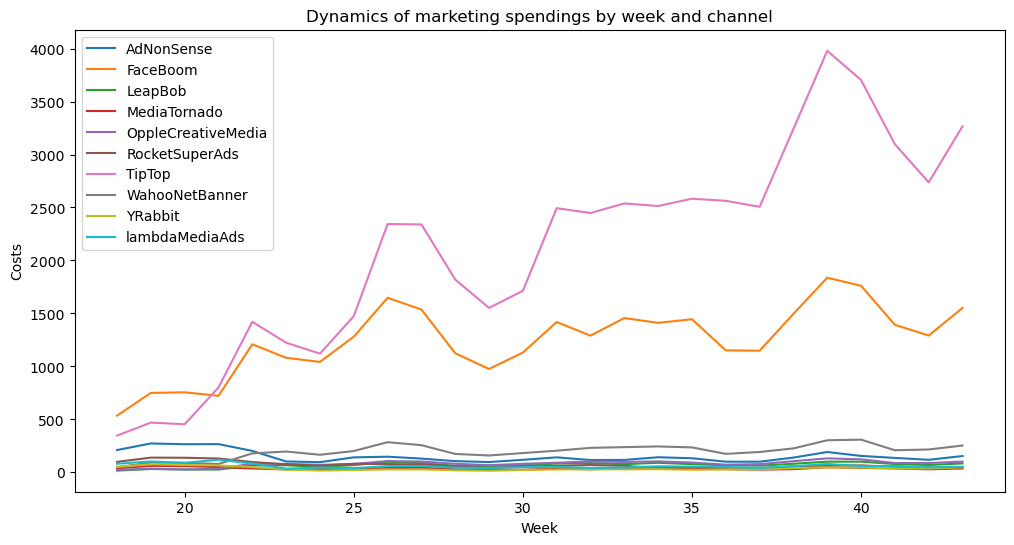

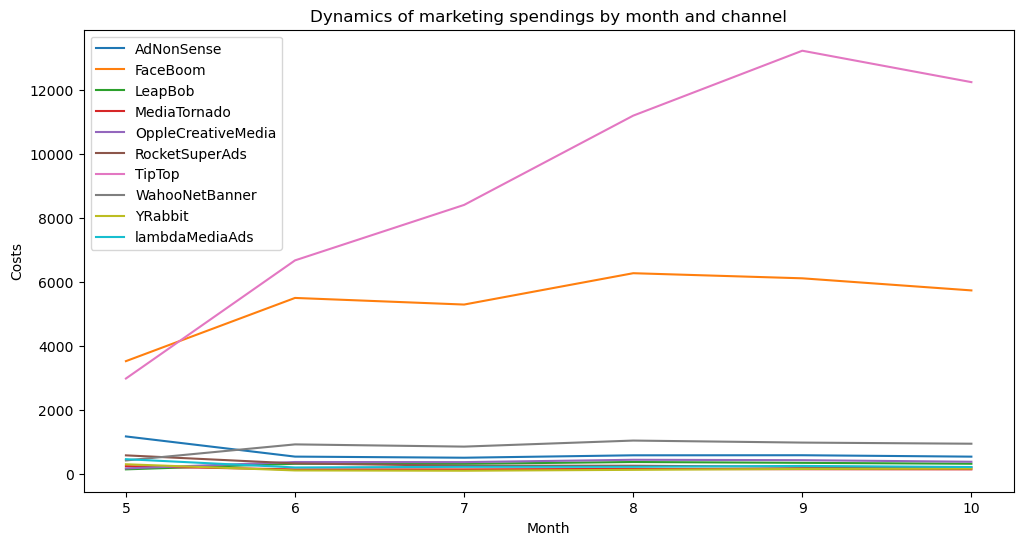

In [56]:
# preparing the DataFrame for visualization
costs_with_wm = costs
costs['dt'] = pd.to_datetime(costs['dt'])
costs_with_wm['week'] = costs['dt'].dt.isocalendar().week
costs_with_wm['month'] = costs_with_wm['dt'].dt.month

plt.figure(figsize=(12, 6))
for channel, data in costs_with_wm.groupby('channel'):
    data.groupby('week')['costs'].sum().plot(label=channel)
plt.title('Dynamics of marketing spendings by week and channel')
plt.xlabel('Week')
plt.ylabel('Costs')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for channel, data in costs_with_wm.groupby('channel'):
    data.groupby('month')['costs'].sum().plot(label=channel)
plt.title('Dynamics of marketing spendings by month and channel')
plt.xlabel('Month')
plt.ylabel('Costs')
plt.legend()
plt.show()

**Summary:**

- The graphs show that the most significant changes occurred in the advertising costs through FaceBoom and TipTop channels.
- The most unstable company in terms of expenses is TipTop. Its costs nearly doubled over three months: in June just over 6000 currency units were spent on it, while in September it was already over 12000 currency units.
- The cost of advertising spendings on FaceBoom did not increase as sharply. Over five months, its cost rose from 4000 to 6000 per month.

#### Average cost of customer acquisition by channel

In [59]:
profiles.groupby(by='channel').agg({'acquisition_cost':'median'}).sort_values(by='acquisition_cost', ascending=False)

acquisition_cost
channel                             
TipTop                      3.000000
FaceBoom                    1.114667
AdNonSense                  1.004348
lambdaMediaAds              0.733333
WahooNetBanner              0.600000
RocketSuperAds              0.404444
OppleCreativeMedia          0.250000
MediaTornado                0.220926
YRabbit                     0.214286
LeapBob                     0.210000
organic                     0.000000

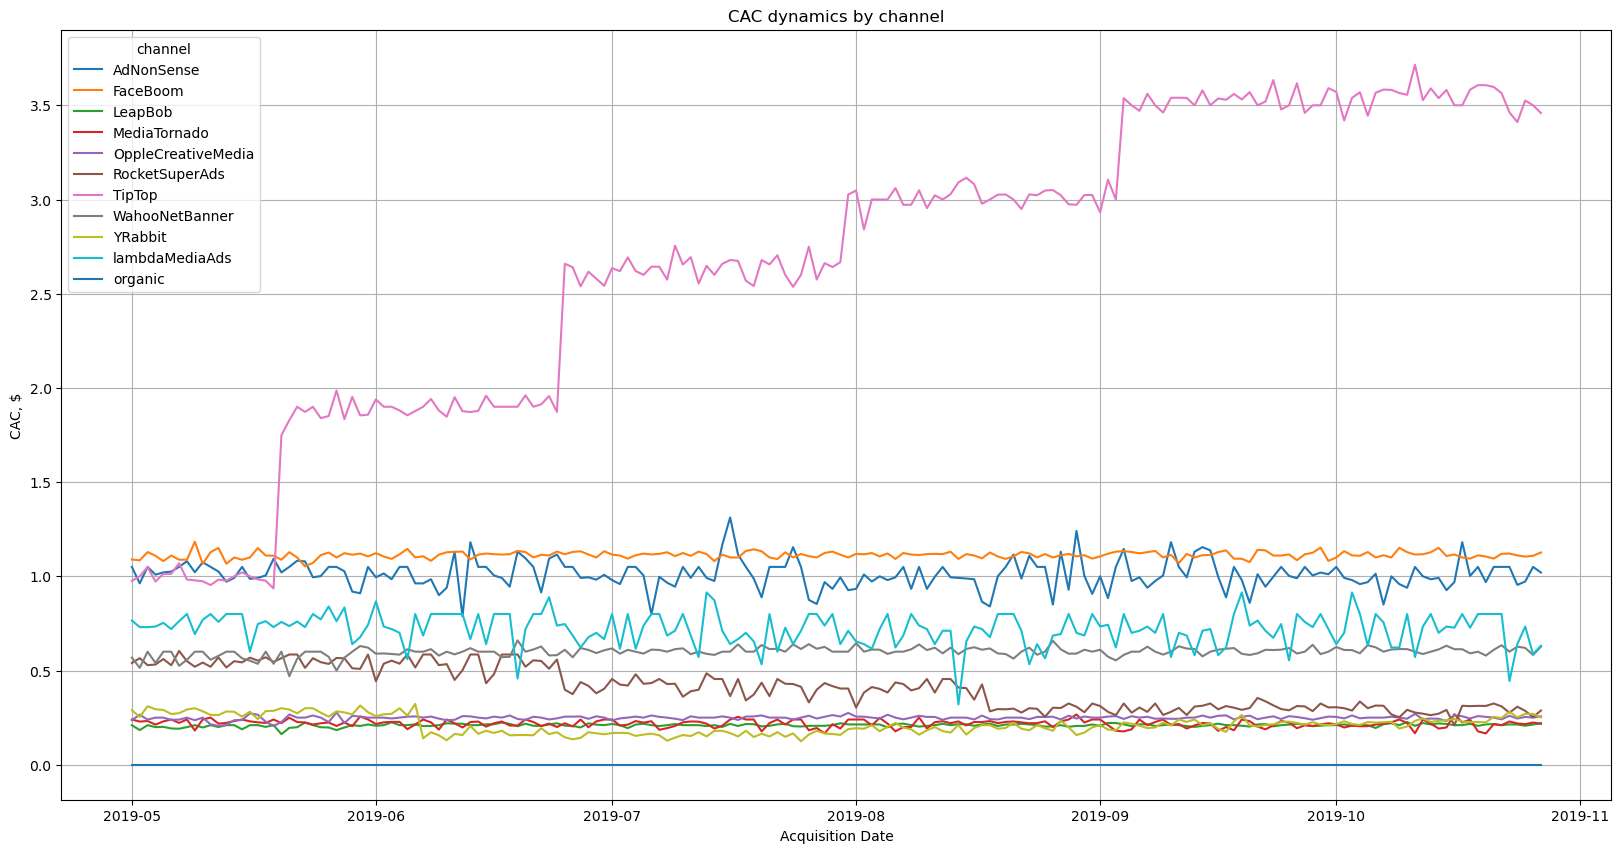

In [60]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='median'
).plot(grid=True, figsize=(20, 10))
plt.ylabel('CAC, $')
plt.xlabel('Acquisition Date')
plt.title('CAC dynamics by channel')
plt.show()

**Summary:**

- FaceBoom did not change the average cost of acquiring a user; it remained stable throughout the entire period.
- TipTop grew from 1 currency unit per user to 3.5 currency units over five months
- Other companies showed minor fluctuations in cost per user (approximately 0.25 currency units).

**Total summary:**

We identified two channels that constituted the main expenses: FaceBoom and TipTop. Notably, FaceBoom did not change the cost of acquiring a single user. The increased expenses for this company can be justified by the fact that the costs were entirely warranted — FaceBoom simply began attracting more users month by month. The situation with TipTop is much more suspicious — the cost of acquiring a single user rose rapidly each month, along with the advertising expenses. TipTop brought in 10 000 fewer new users than FaceBoom, yet company paid it 22 000 more.

### Basic analysis of metrics dynamic (no dimensions)

#### LTV, CAC and ROI

In [65]:
# defining the analysis period
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

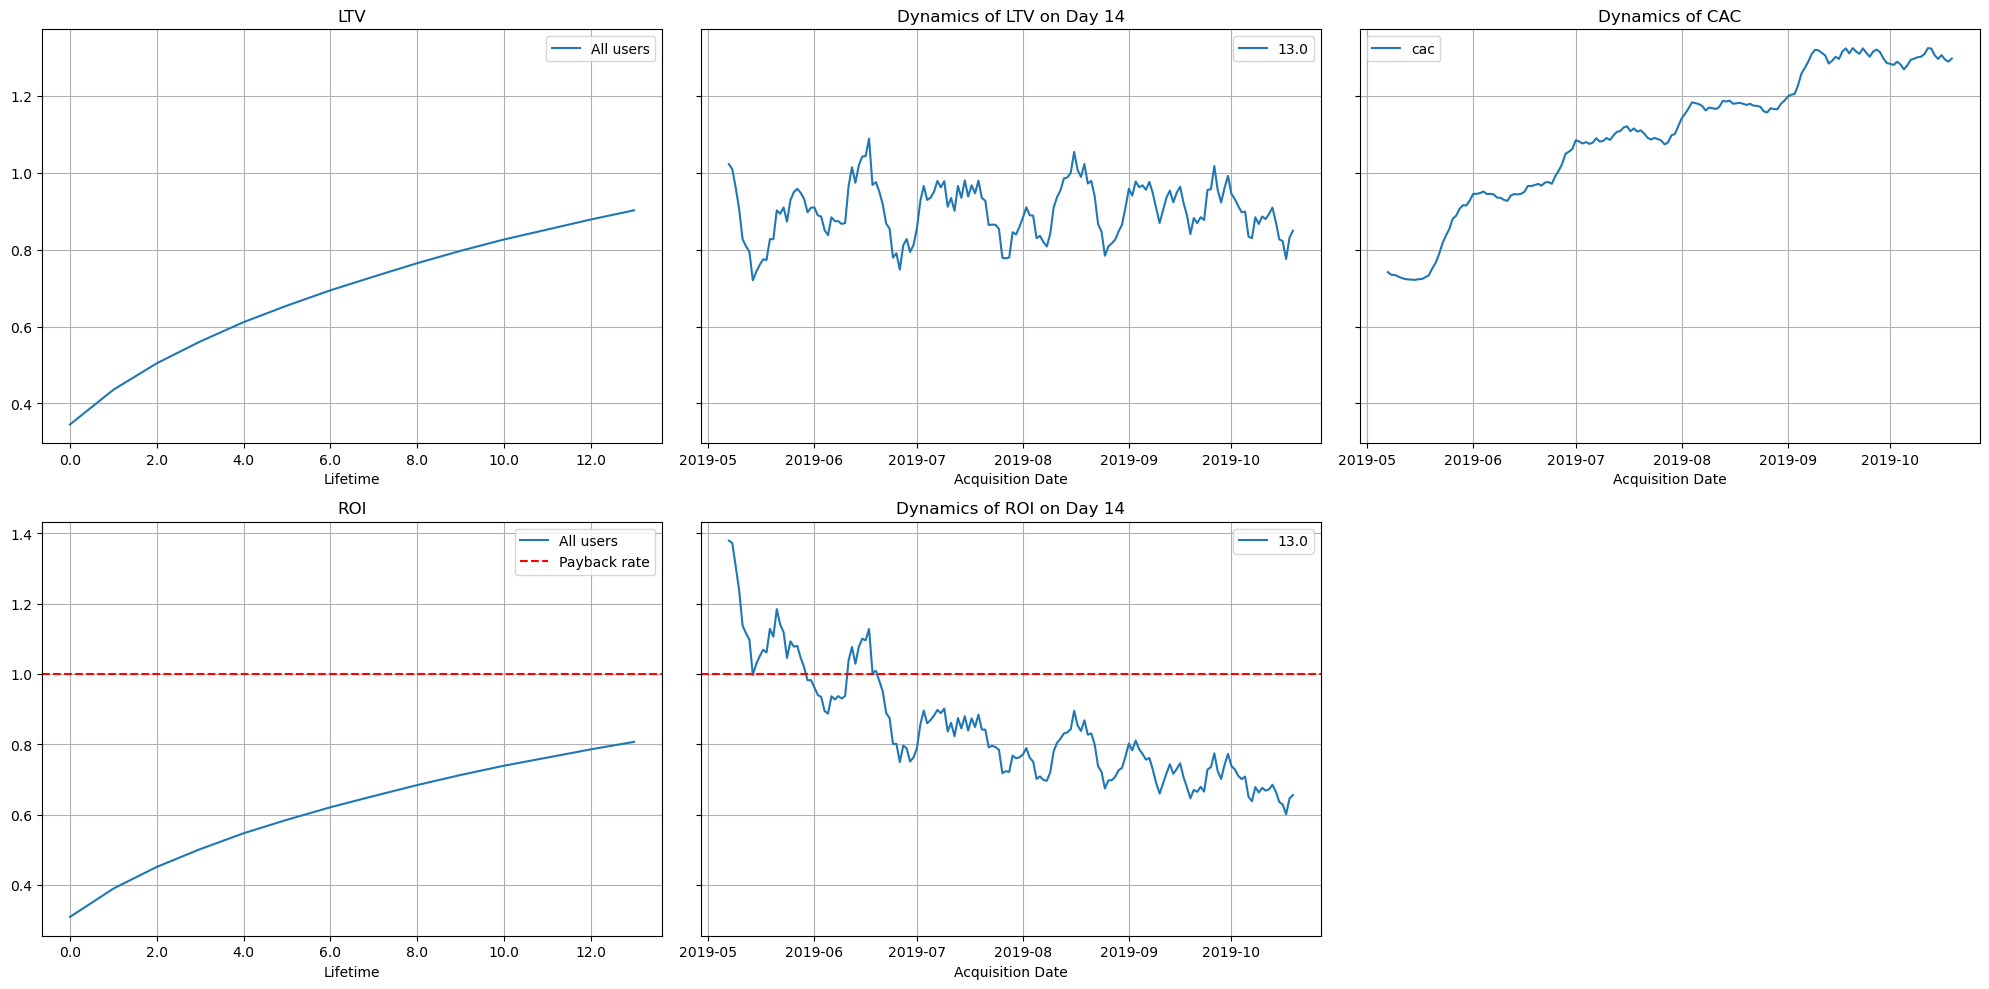

In [66]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Summary:**
- LTV shows seasonal fluctuations but is generally stable
- ROI does not reach breakeven level by the 14th day.
- ROI decreases month by month, while CAC (Customer Acquisition Cost) increases each month. Here’s the answer: it’s due to the rapid increase in the budget for user acquisition.

#### Conversion

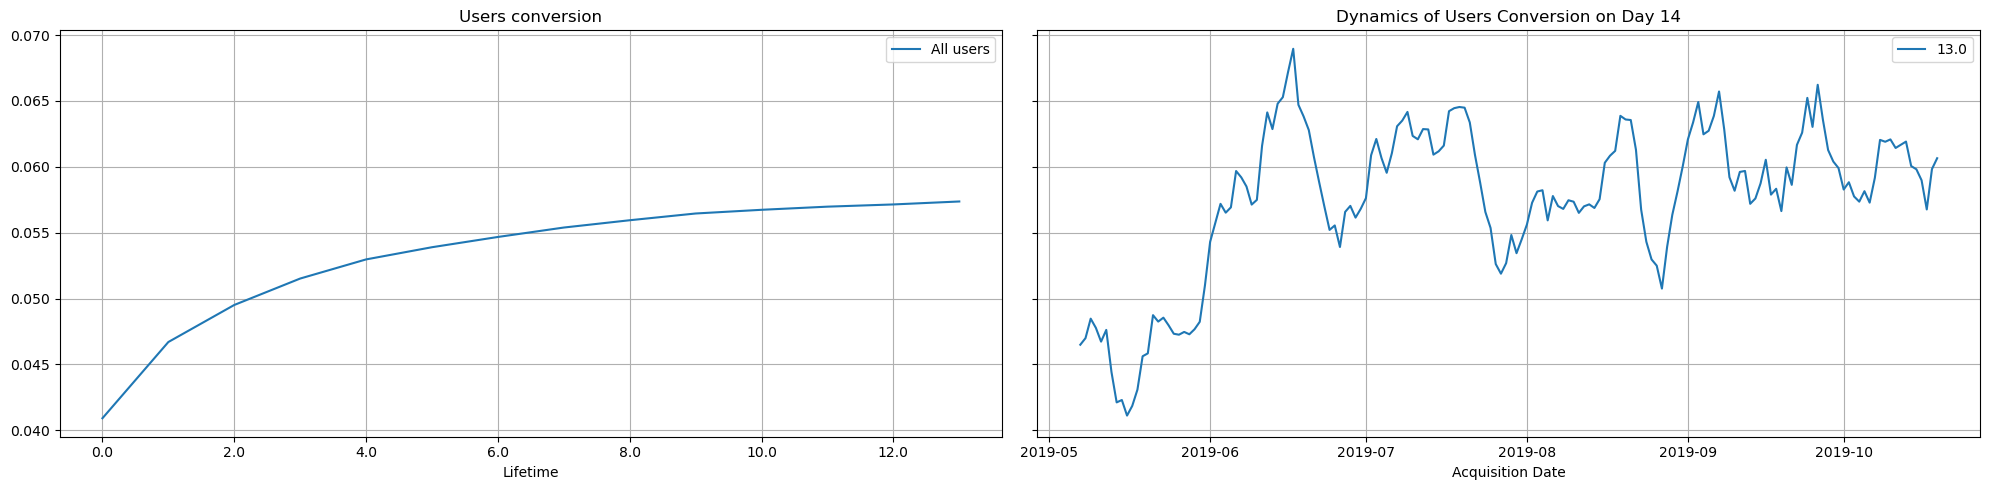

In [69]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Summary:** The graphs indicate that the overall conversion rate is not the source of the problems — its dynamics are positive

#### Retention

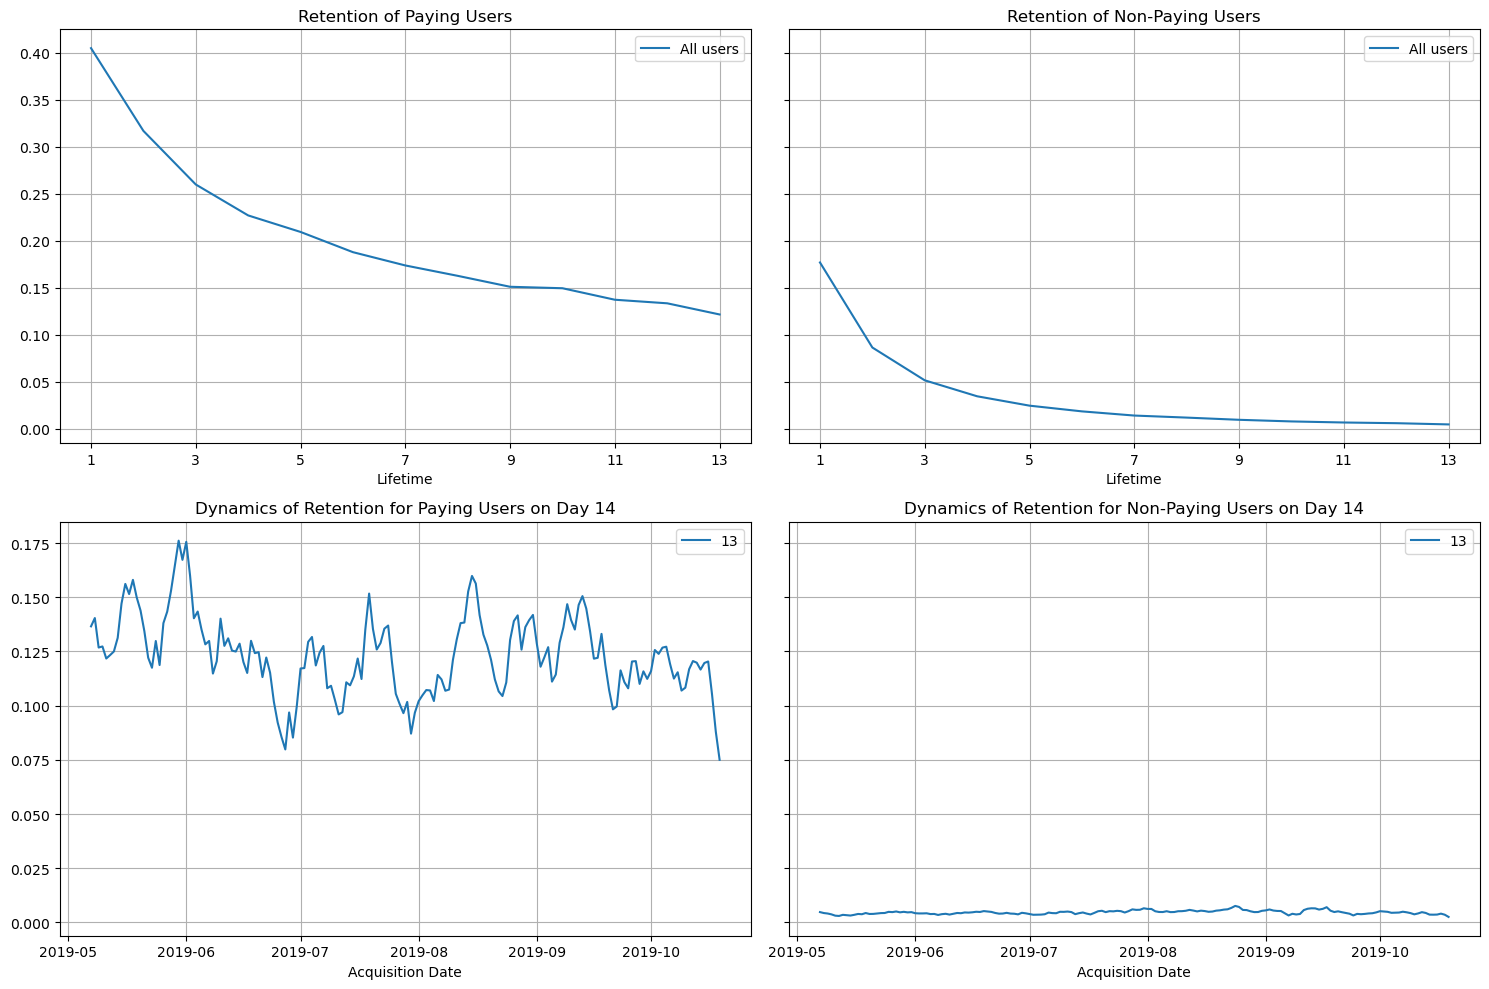

In [72]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Summary:** we see that the retention of non-paying users is stable. Retention among paying users is slowly decreasing. However, it is too early to talk about a serious problem here 

### Detailed analysis of metrics dynamic (with dimensions)

#### LTV, CAC and ROI by device type

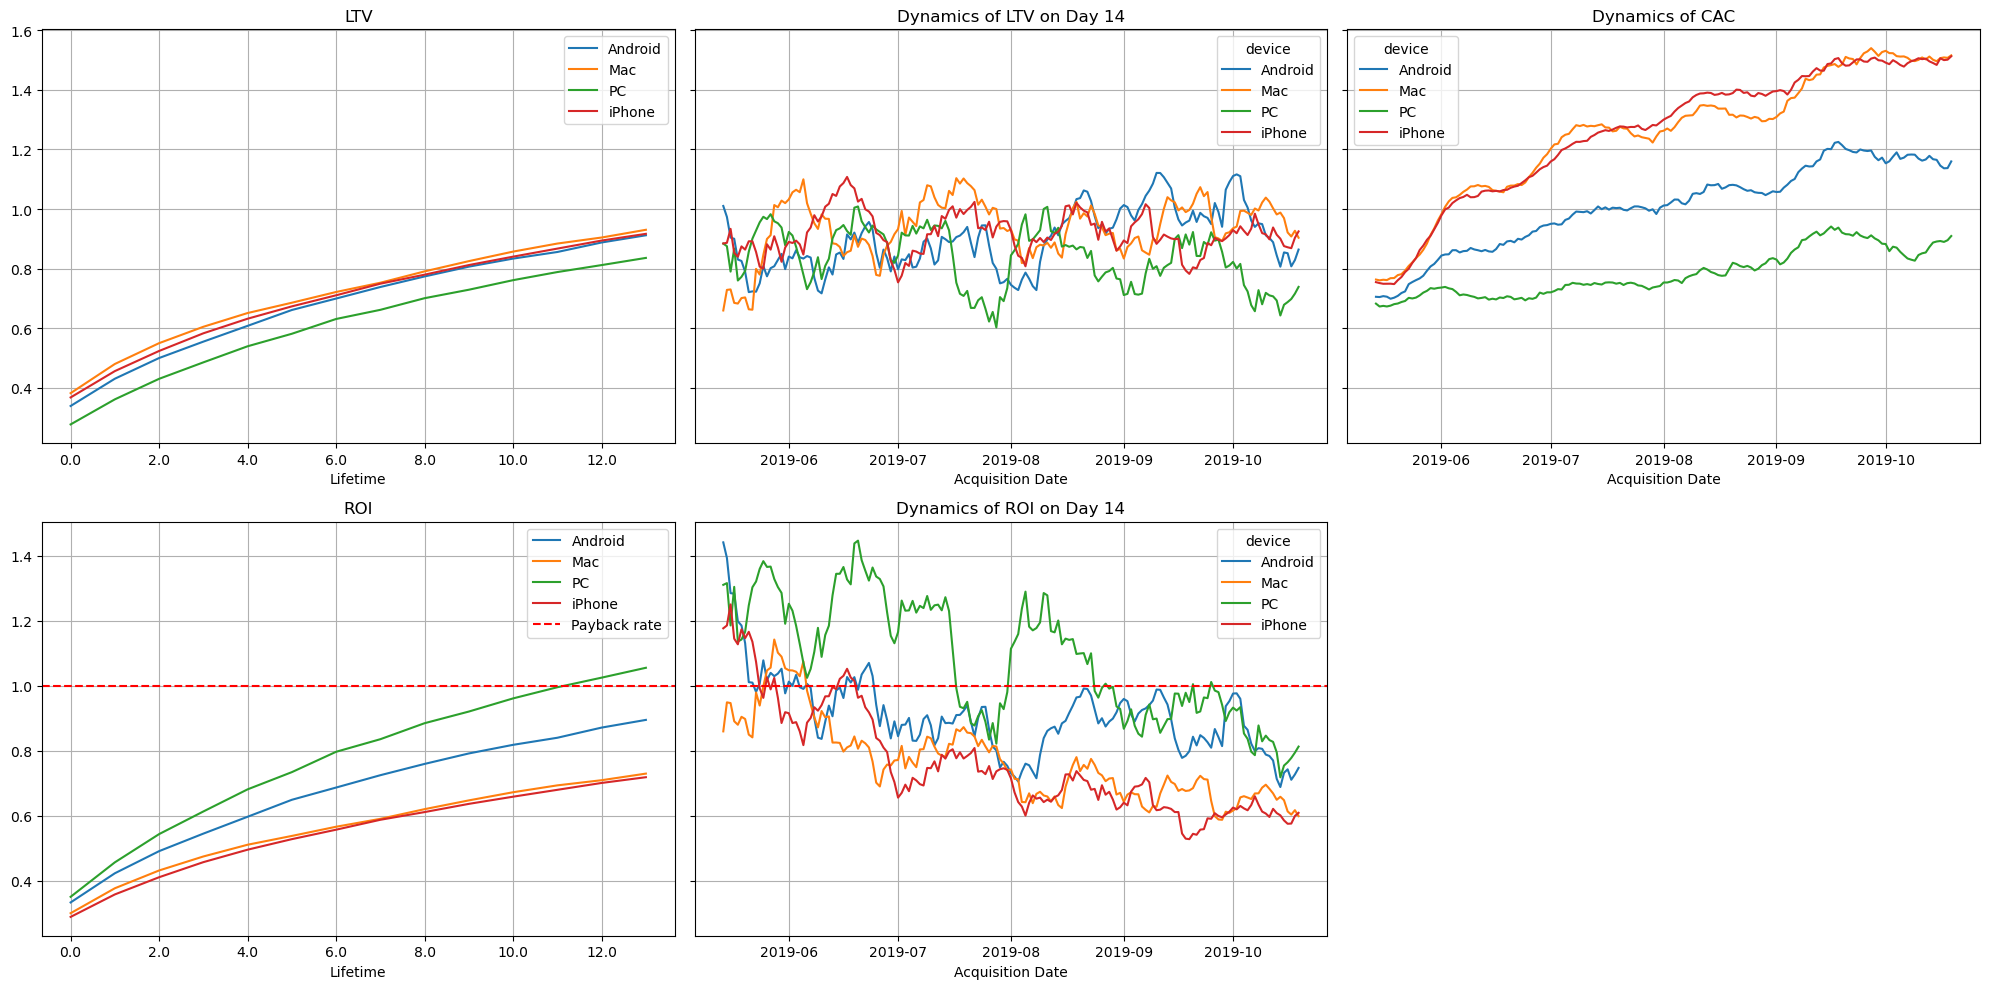

In [76]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Summary:**
- LTV for different devices does not differ significantly, and its overall picture is stable.
- ROI only reaches breakeven line for PC users, other "devices" are quite unprofitable. We see significant upward fluctuations in breakeven level for PCs in different months.
- The overall picture for ROI is negative for all devices, its values are decreasing each month.
- The cost of acquiring users has significantly increased for all devices. However, Apple products are in the lead here. Most likely, the ROI for this device is lower than the breakeven level because of this fact.

#### LTV, CAC and ROI by region

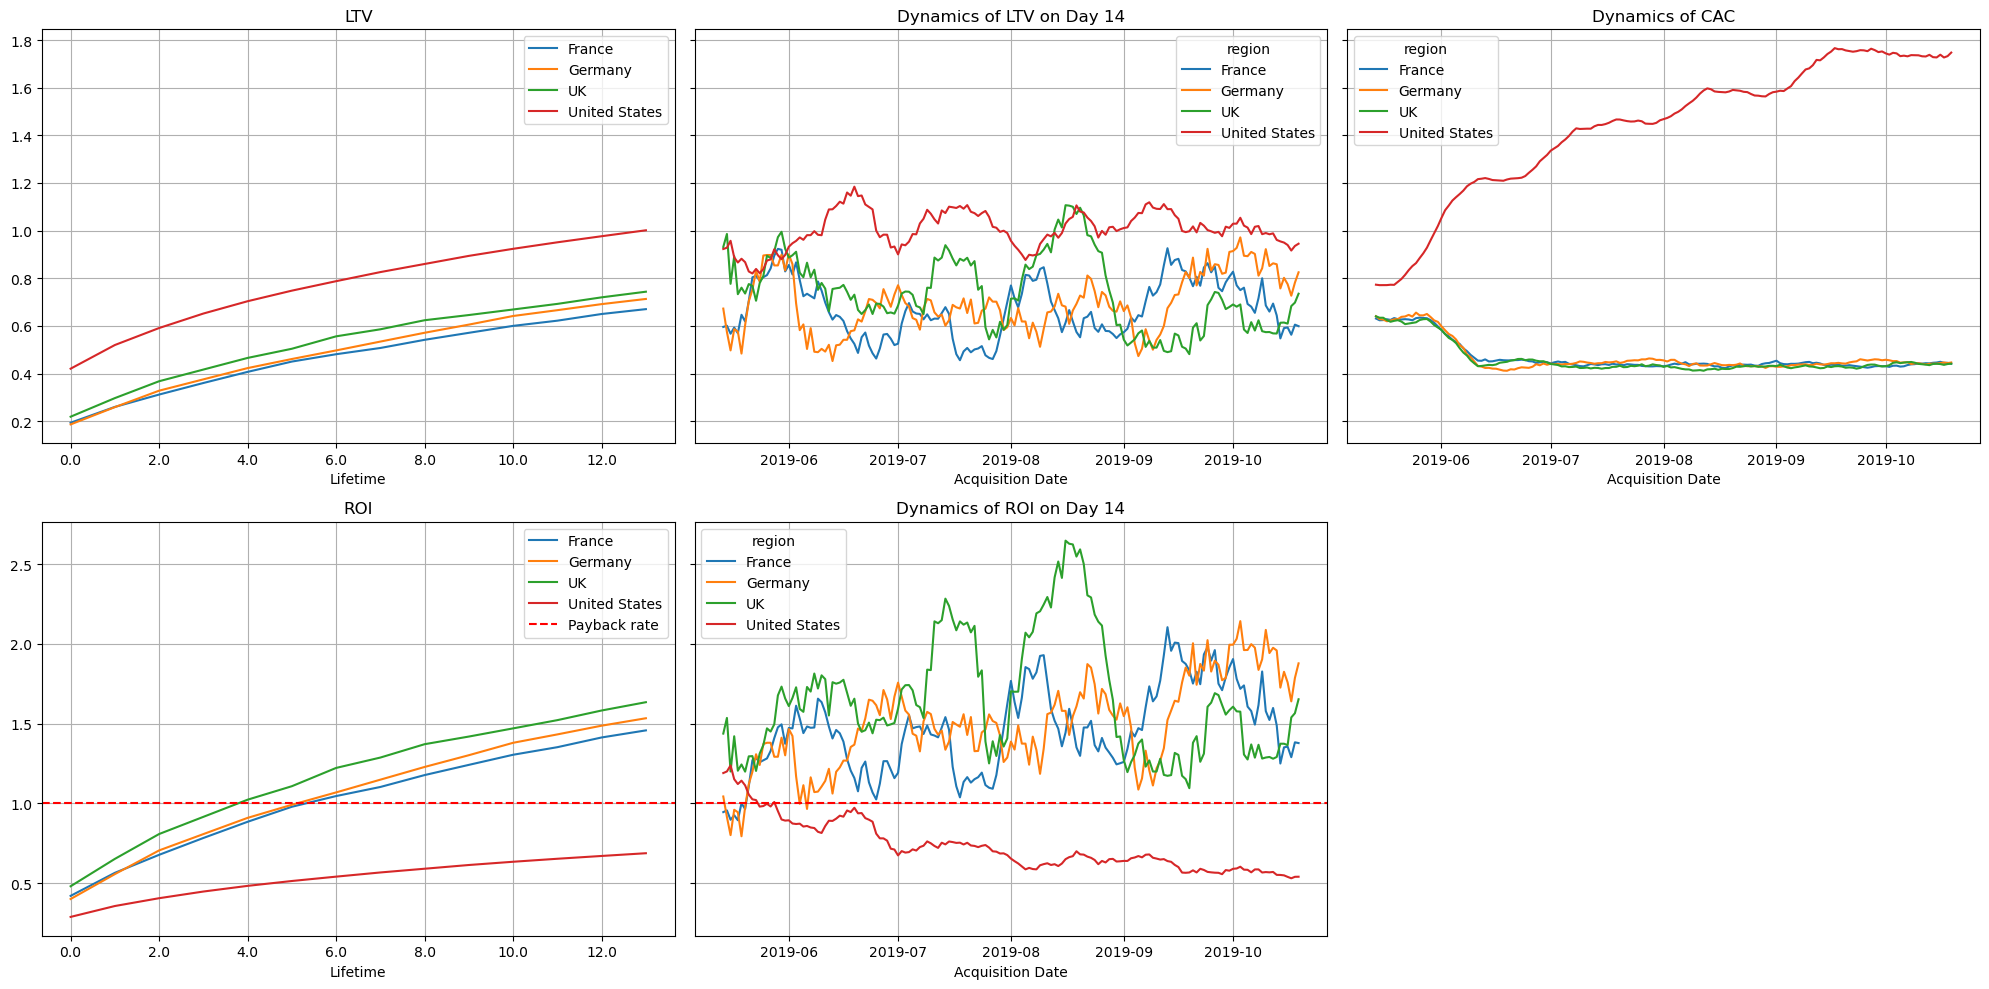

In [79]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Summary:**

- The main conclusion here is that we have identified the localization of the problem. The USA is the only country where advertising is not profitable. In contrast, the metrics for other countries are increasing each month, while in the USA they are declining. This is closely related to the sharp increase in advertising expenses in this country.
- The other countries have stable metrics, and no issues are visible in them.

#### LTV, CAC and ROI by channel

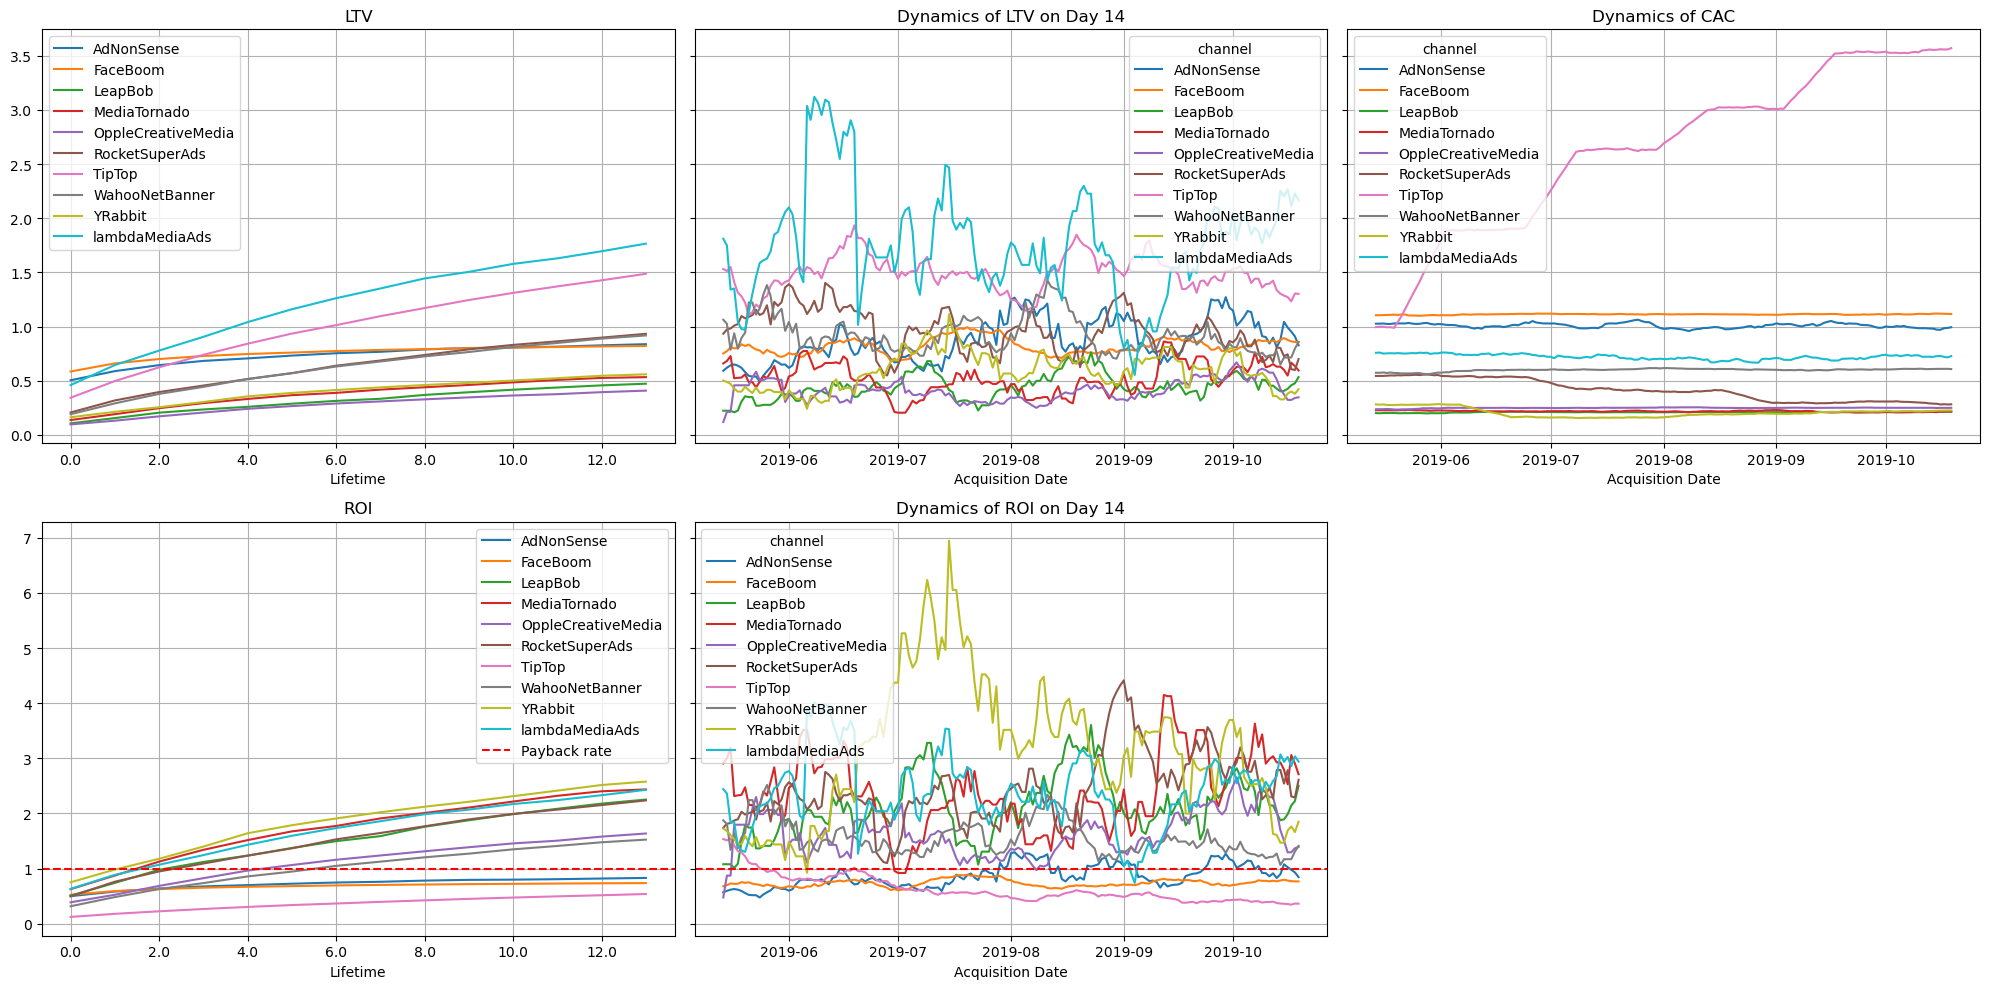

In [82]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[profiles['channel'] != 'organic'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Summary:**

*The least effective channels:*

- TipTop channel showed the lowest efficiency among all other channels. Metrics confirmed the conclusions made earlier: the cost of attracting users was growing rapidly every month, while profitability was decreasing.

- FaceBoom is also not profitable. However, the cost of acquiring a user did not change. It may simply be due to the inflated cost of acquiring a persona. It could also be that the retention of paying users (and the largest share of paying users comes from this source) has been declining over time. Or perhaps this source primarily attracted users of Apple devices or operated only in the USA market. Something may have happened in this market during this time that caused the advertising budget to increase sharply in June.

- AdNonSense is the second source in terms of the share of paying users, and it is also not profitable. It is evident that the decline in retention affects the profitability of advertising: the user came, so the acquisition was paid by Procrastinate Pro+, but this user made a couple of purchases and then "disappeared".

*The most effective channels:*
- The most pronounced channel in terms of profitability is YRabbit. Its cost of acquiring a user is stable and minimal in comparison to other companies. The advantage of YRabbit is especially evident in the monthly ROI graph — the strongest upward fluctuations belong to it. It is the main contender for budget reallocation.
- LambdaMedia and MediaTornado can also be highlighted as they are in the top three in terms of profitability, and LambdaMedia has the highest LTV among all channels. Attention can also be shifted to them. 

**Total summary.** Based on the conclusions described above, the following problems can be assumed:

- Acquisition Channel:
    - Procrastinate Pro+ is definitely overpaying for TipTop channel, and the largest issue in profit loss lies with this source. This is indicated by the fact that each month company is spending more and more money on this agent.
    - AdNonSense and FaceBoom did not increase the cost of acquiring customers, and they are also leaders in the share of paying users. So what’s the issue? The problem is that retention has sharply declined. Those who should have made the source one of the most profitable were unable to do so - customers were leaving the app too early.

- Devices: It is evident that the profitability is lowest for Apple devices. We can assume there are some technical issues with these devices. Similar problems are also likely for Android devices.

- Country Localization: In the USA most users have Apple products, and this brand has shown a pattern of unprofitability. Moreover, the TipTop channel operates only in the USA. With a not-so-high share of paying users and a constant increase in service prices, it could lead to such a concerning profitability graph in the USA. Verification supporting these claims is provided below.

*Thus, it is necessary to delve deeper into the patterns, dividing countries into groups "USA" and "Europe".*

In [85]:
# extra check for the assumption above 

print(profiles[profiles['channel'] == 'TipTop']['region'].unique())
profiles[profiles['region'] == 'United States'].groupby(by='device').agg({'device':'count'})

['United States']


device
device         
Android   20199
Mac       24842
PC        10432
iPhone    44529

#### Conversion dynamics in USA by channel

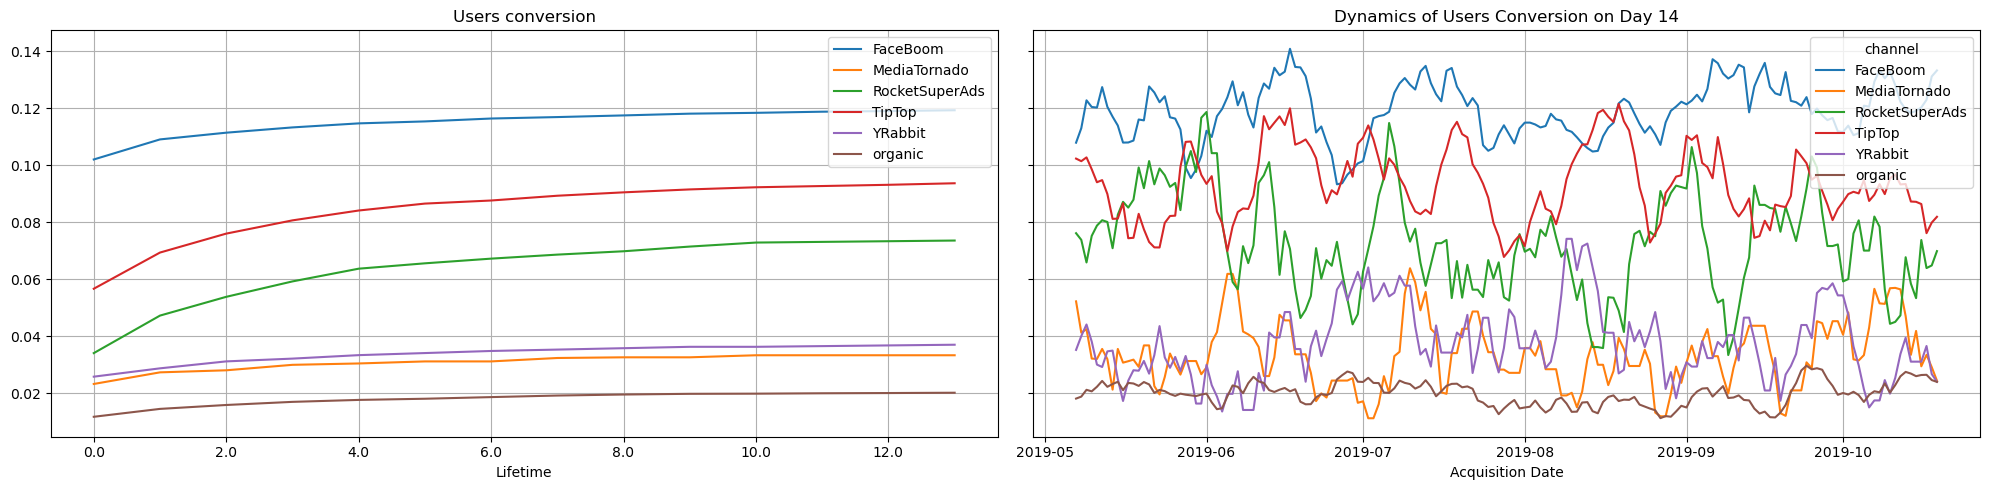

In [87]:
dimensions=['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['region'] == 'United States'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

#### Retention dynamics in USA by channel

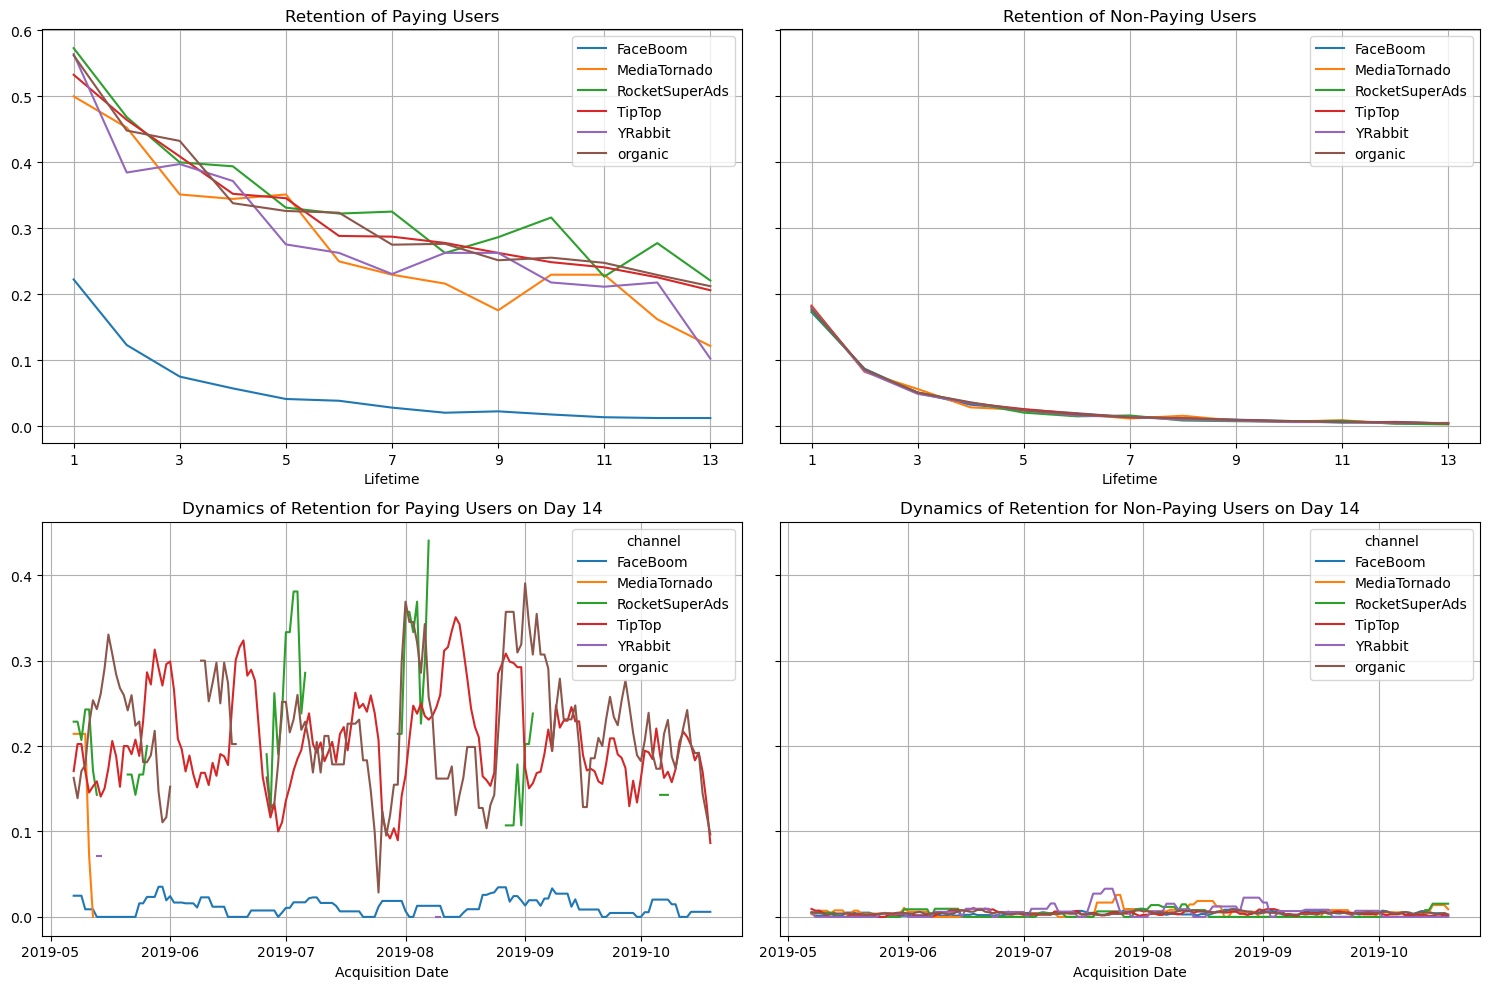

In [89]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['region'] == 'United States'], visits[visits['region'] == 'United States'], observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### LTV, CAC and ROI dynamics in USA by channel

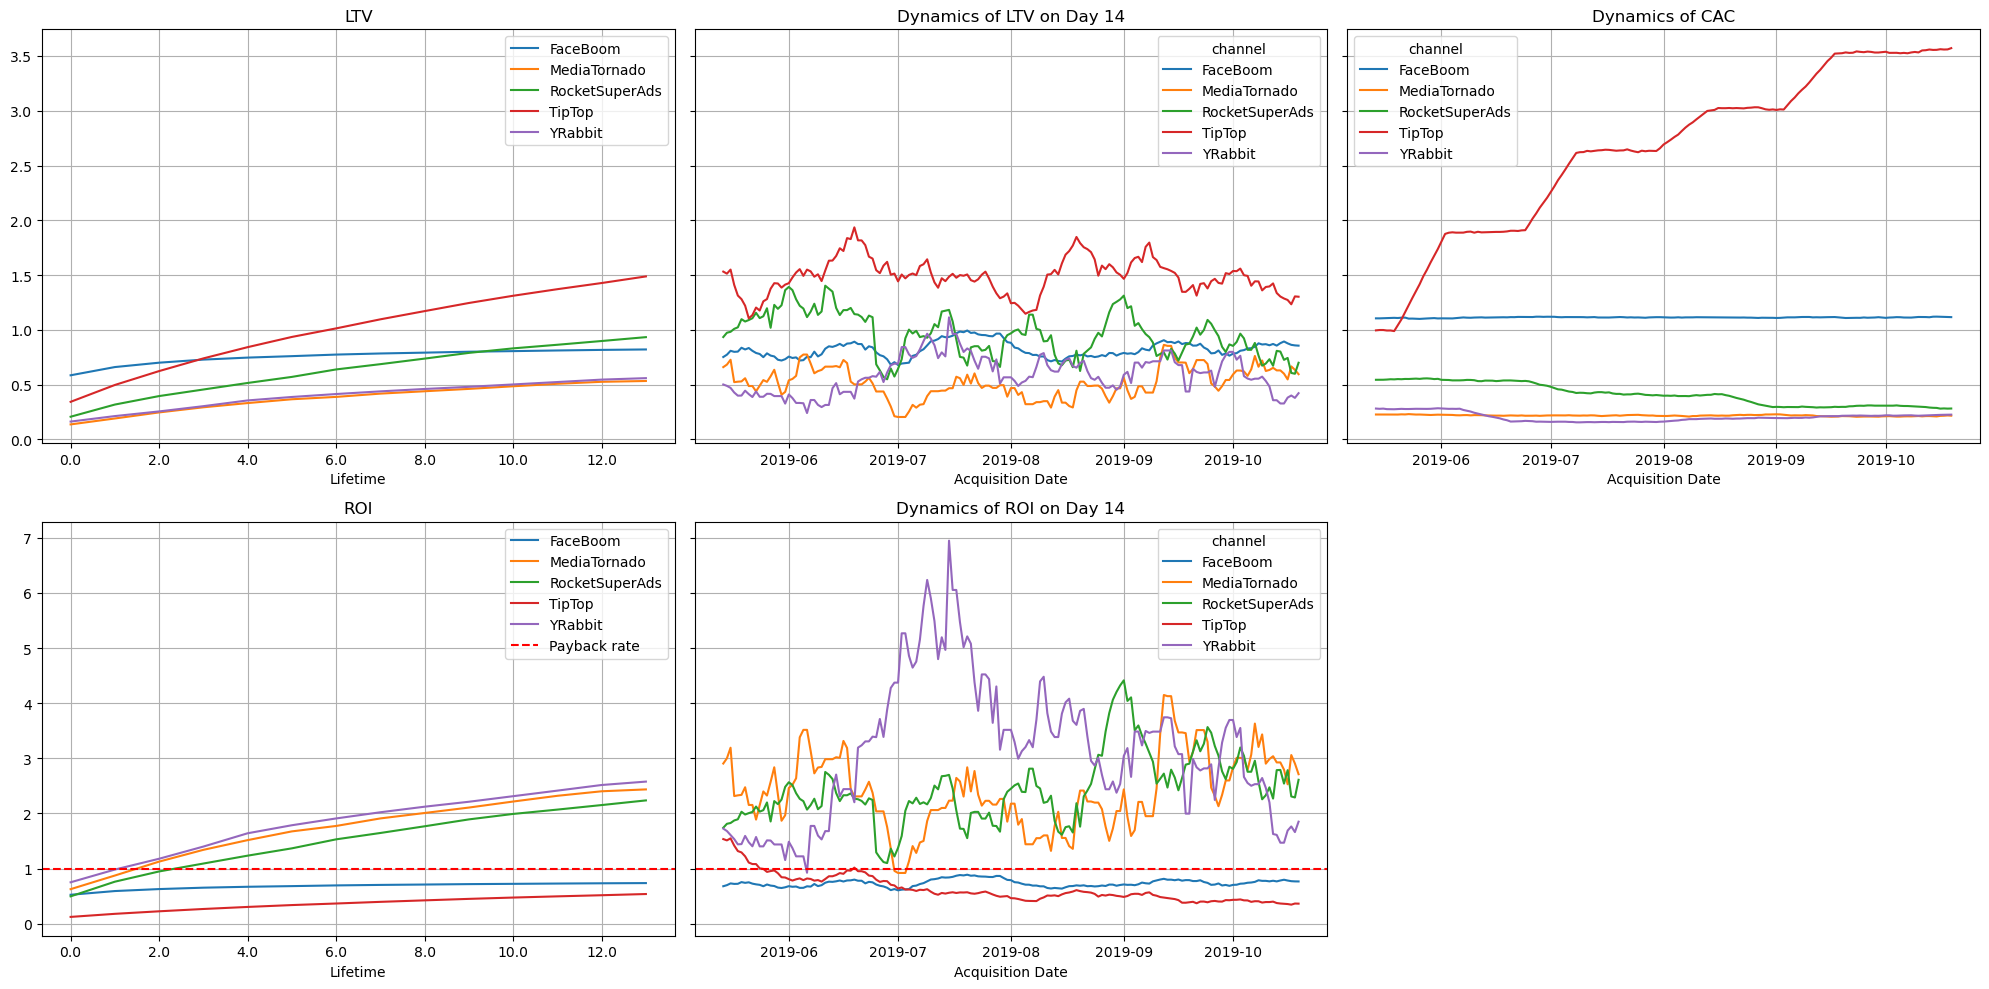

In [91]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[(profiles['channel'] != 'organic')&(profiles['region'] == 'United States')], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Summary:** LTV and retention of non-paying users is normal, but paying users are on the decline. FaceBoom has the lowest retention rate, and it hardly drops because it has always been at a minimum. Profitability is on the side of three channels: YRabbit, RocketSuperAds and Media Tornado. The second channel among them also has the second highest LTV. Thus, these are the channels to focus on for spendings reallocation in the USA.

#### Conversion dynamics in USA by device

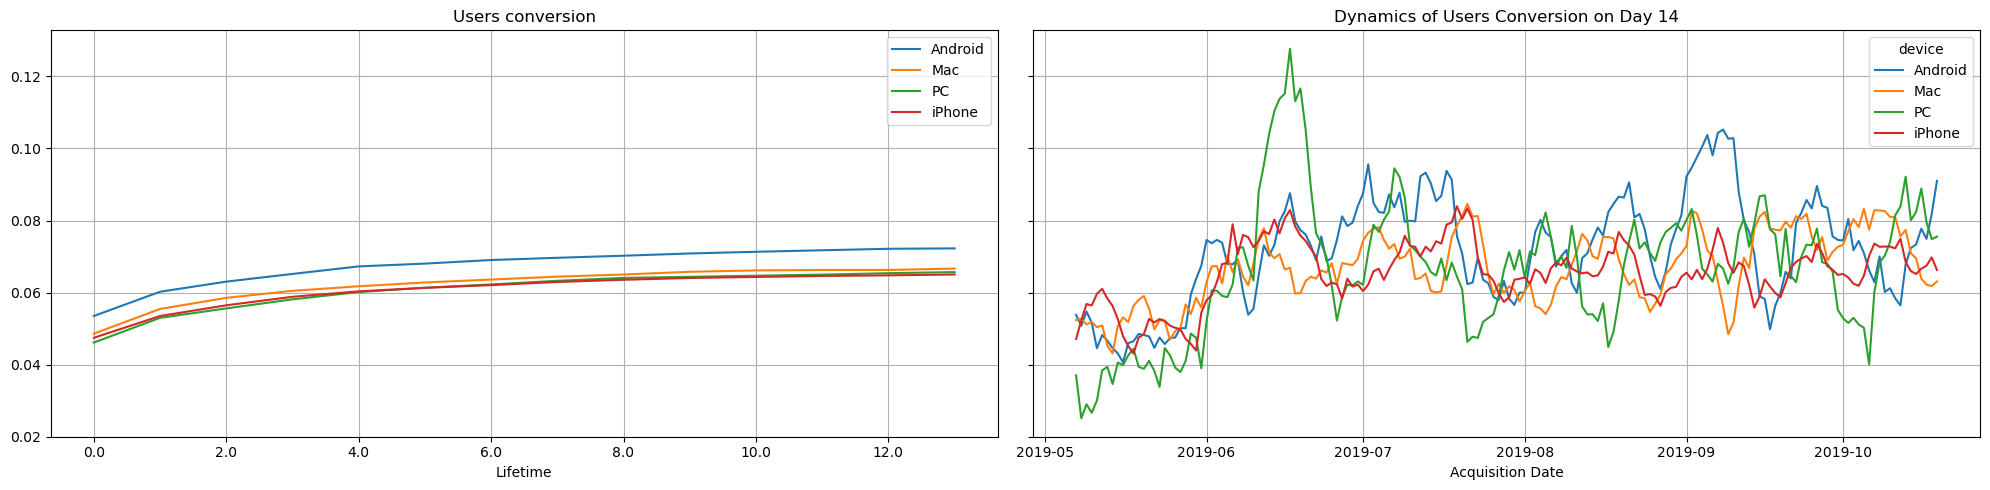

In [94]:
dimensions=['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['region'] == 'United States'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

#### Retention dynamics in USA by device

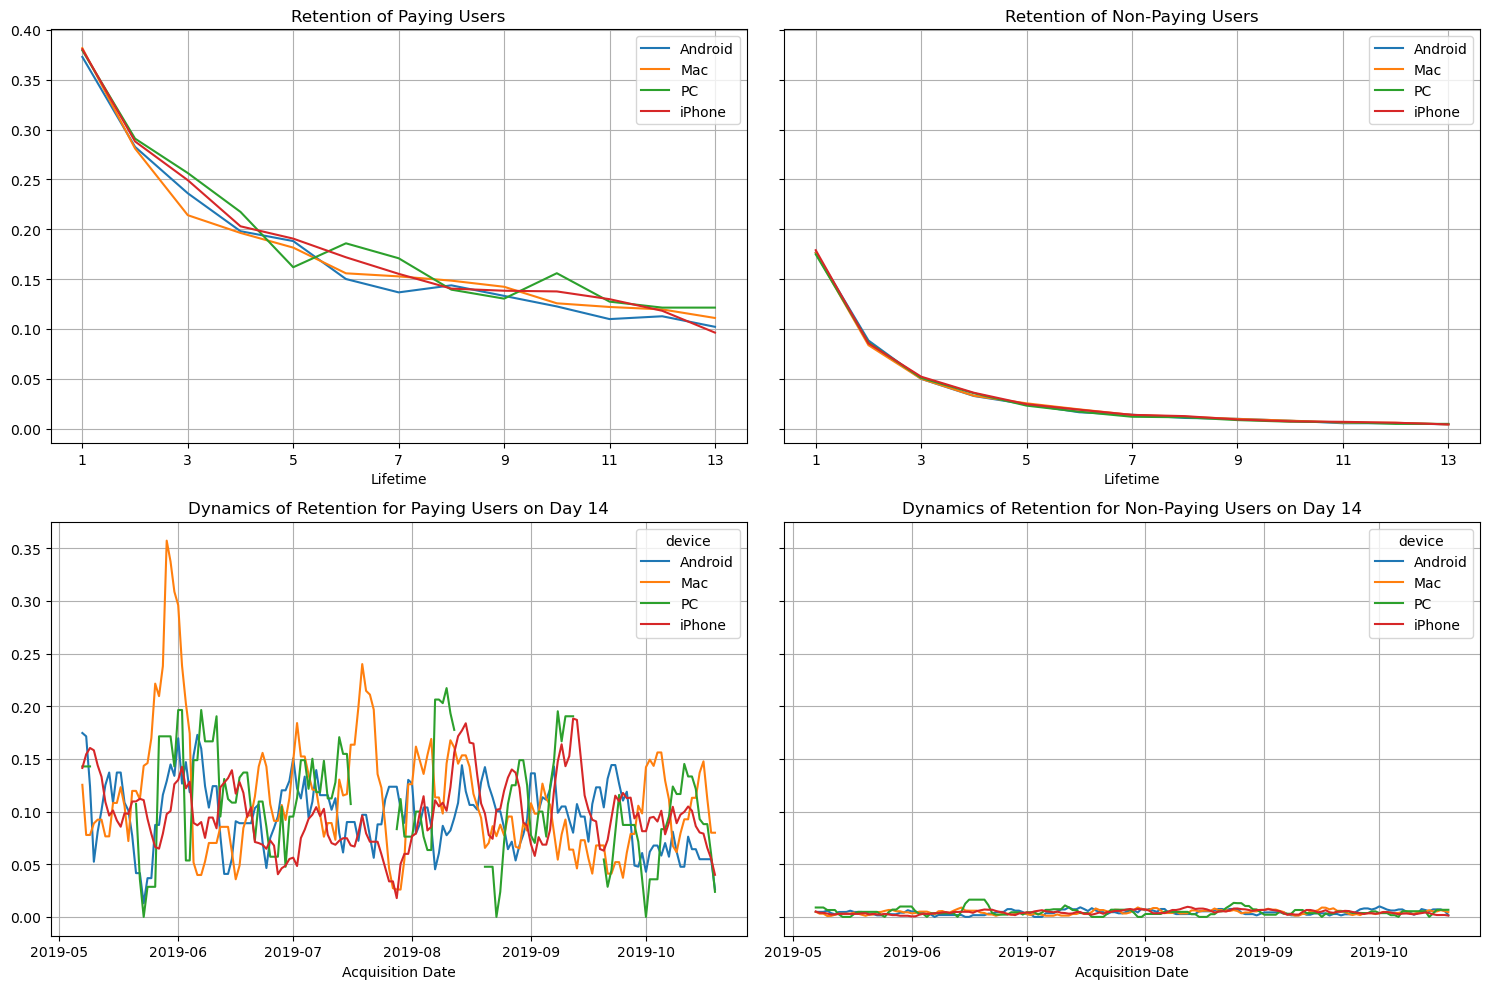

In [96]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['region'] == 'United States'], visits[visits['region'] == 'United States'], observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### LTV, CAC and ROI dynamics in USA by device

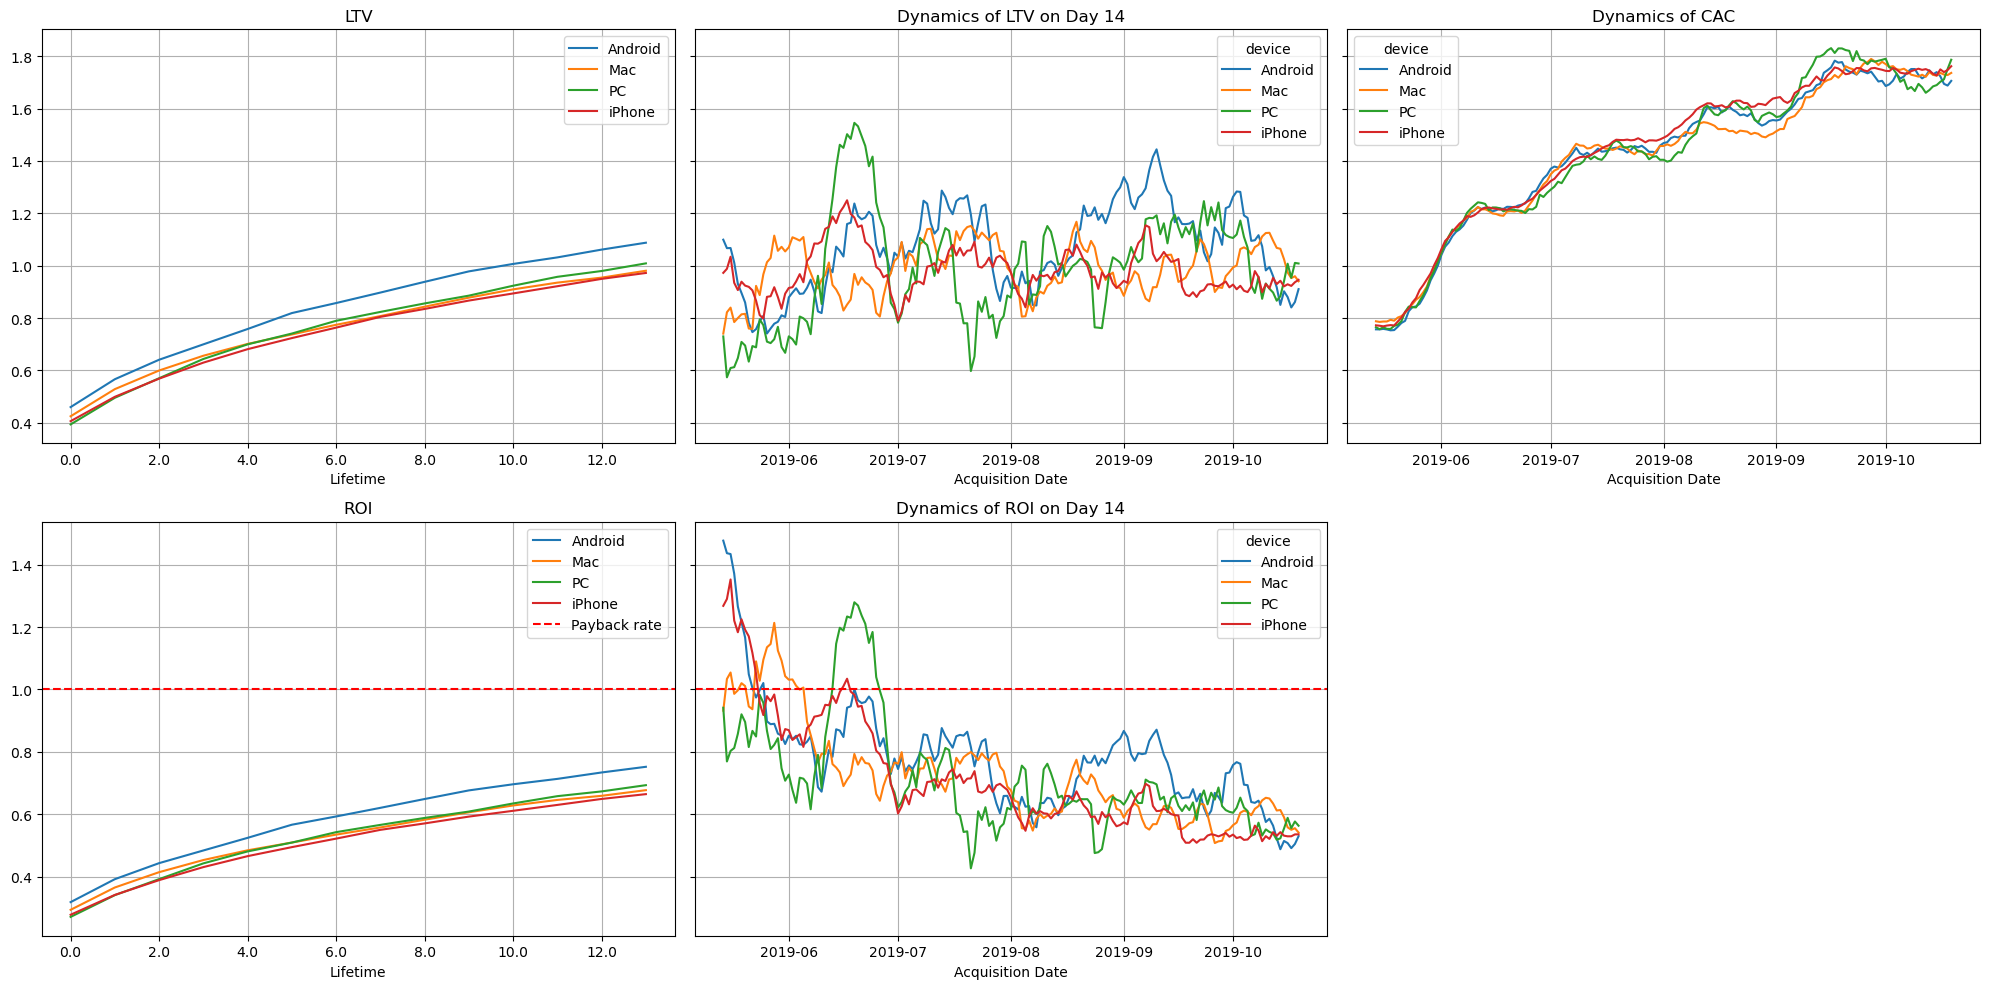

In [98]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[(profiles['channel'] != 'organic')&(profiles['region'] == 'United States')], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Summary:** LTV in the USA by devices is normal, retention of non-paying users is normal, but paying users are on the decline. It is not possible to single out the most “suffering” devices, as each of them is declining rapidly and evenly. Profitability has not been achieved on any of the devices. CAC is also increasing rapidly for each device.

#### Conversion dynamics in Europe by channel

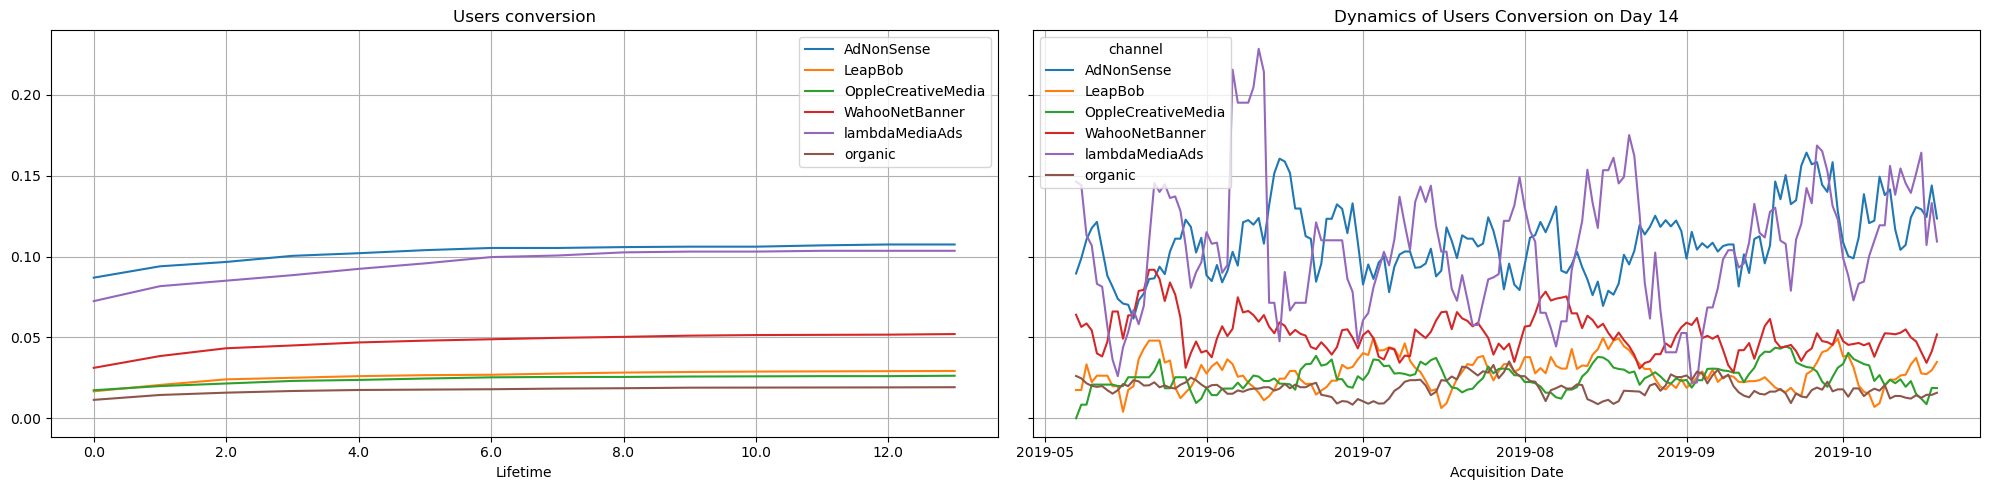

In [101]:
dimensions=['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['region'] != 'United States'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

#### Retention dynamics in Europe by channel

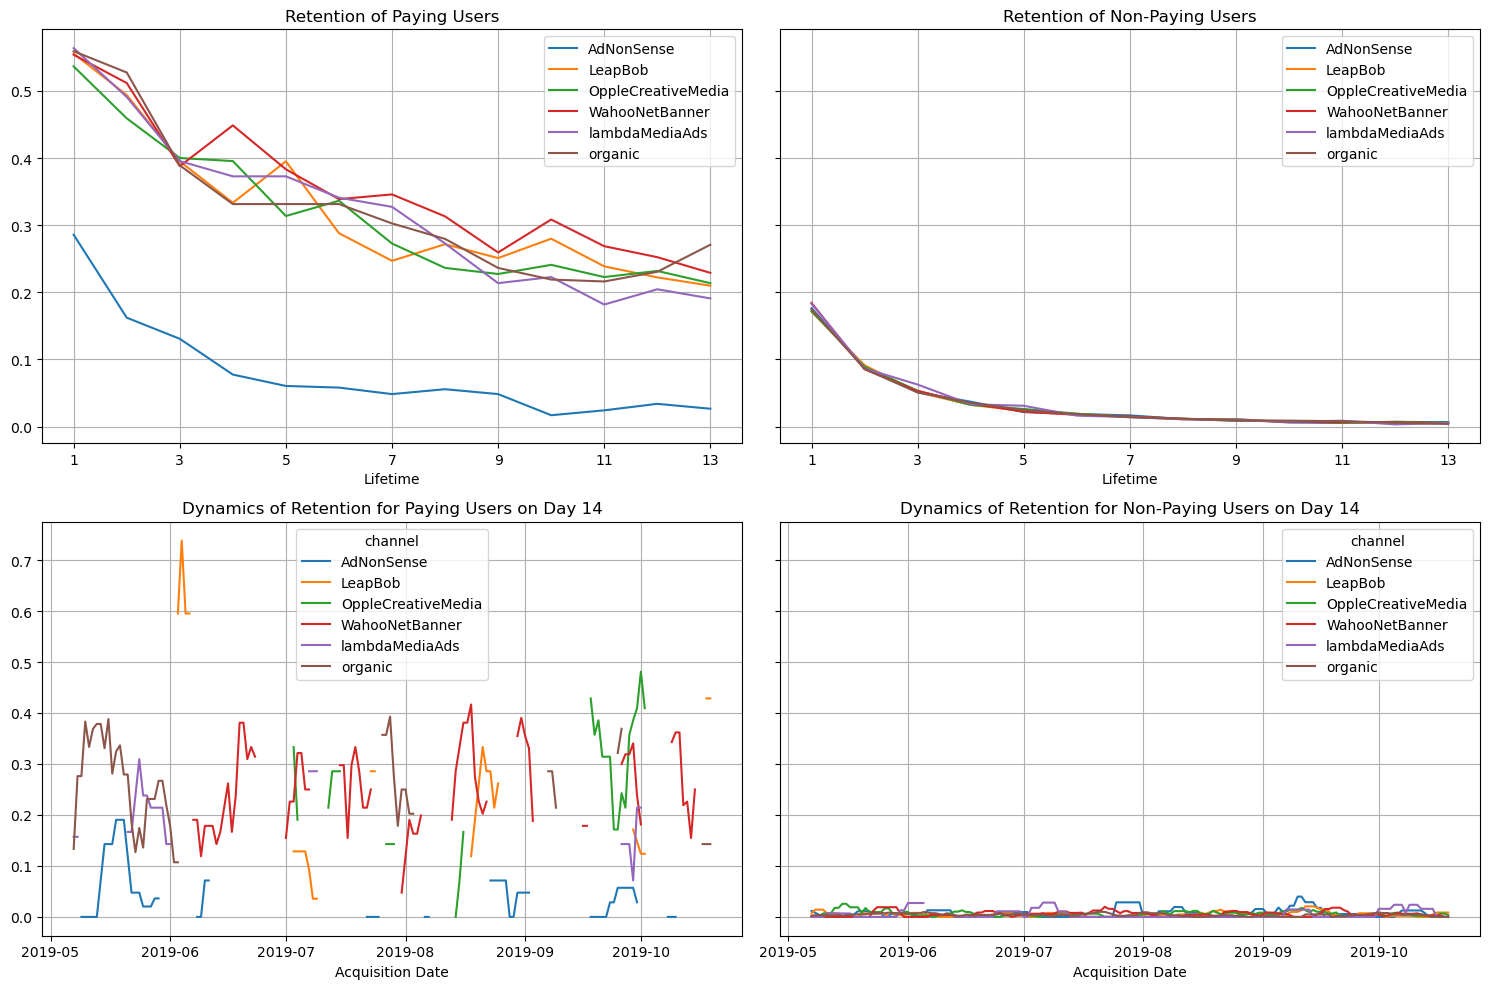

In [103]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['region'] != 'United States'], visits[visits['region'] != 'United States'], observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### LTV, CAC and ROI dynamics in Europe by channel

In [105]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[(profiles['channel'] != 'organic')&(profiles['region'] != 'United States')], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Summary:** LTV in Europe by channels is almost stable, showing a slow upward trend, retention of non-paying users is normal, but paying users are also on the decline. The situation is worst with AdNonSense channel as the retention there is the lowest. This channel is the only one that is not profitable in Europe, yet its CAC is the highest. All other channels do not need to be reviewed, they are successfully doing their job. Special attention should be given to LeapBob and lambdaMediaAds - they are the most profitable.

#### Conversion dynamics in Europe by device

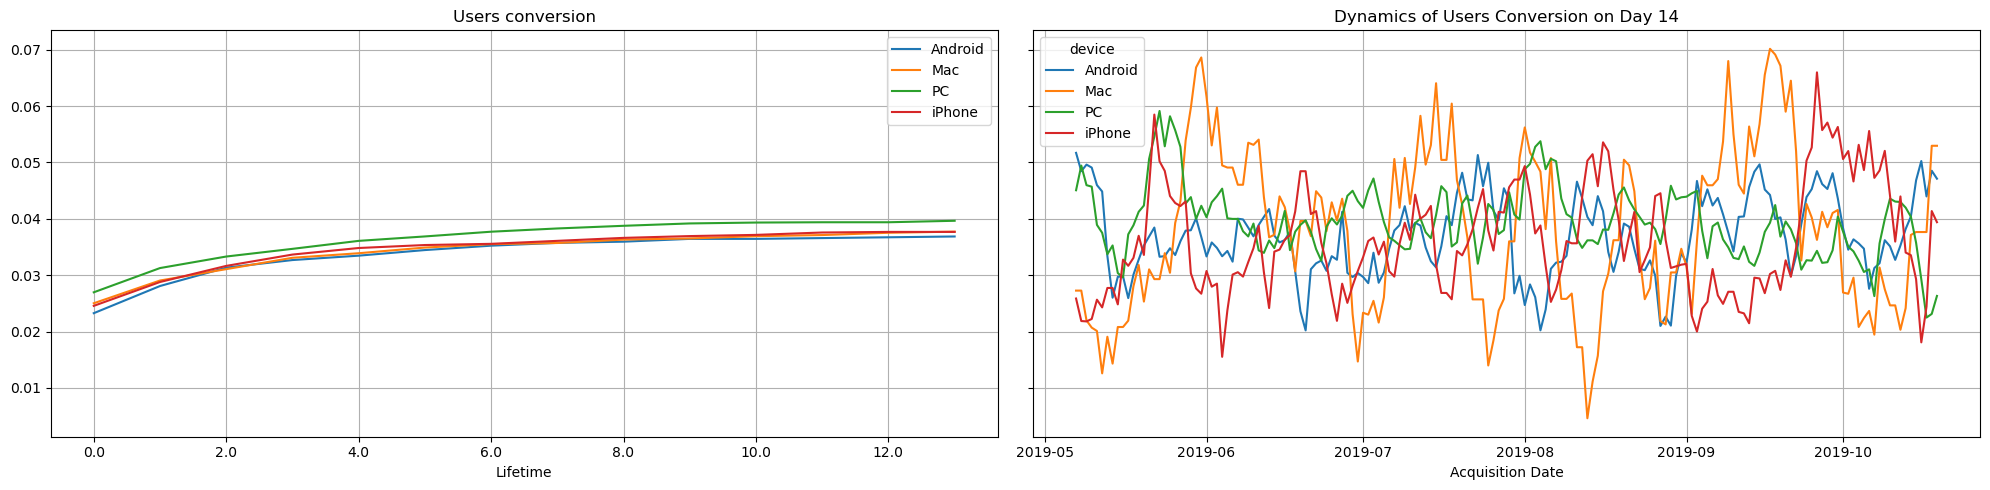

In [108]:
dimensions=['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles[profiles['region'] != 'United States'], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

#### Retention dynamics in Europe by device

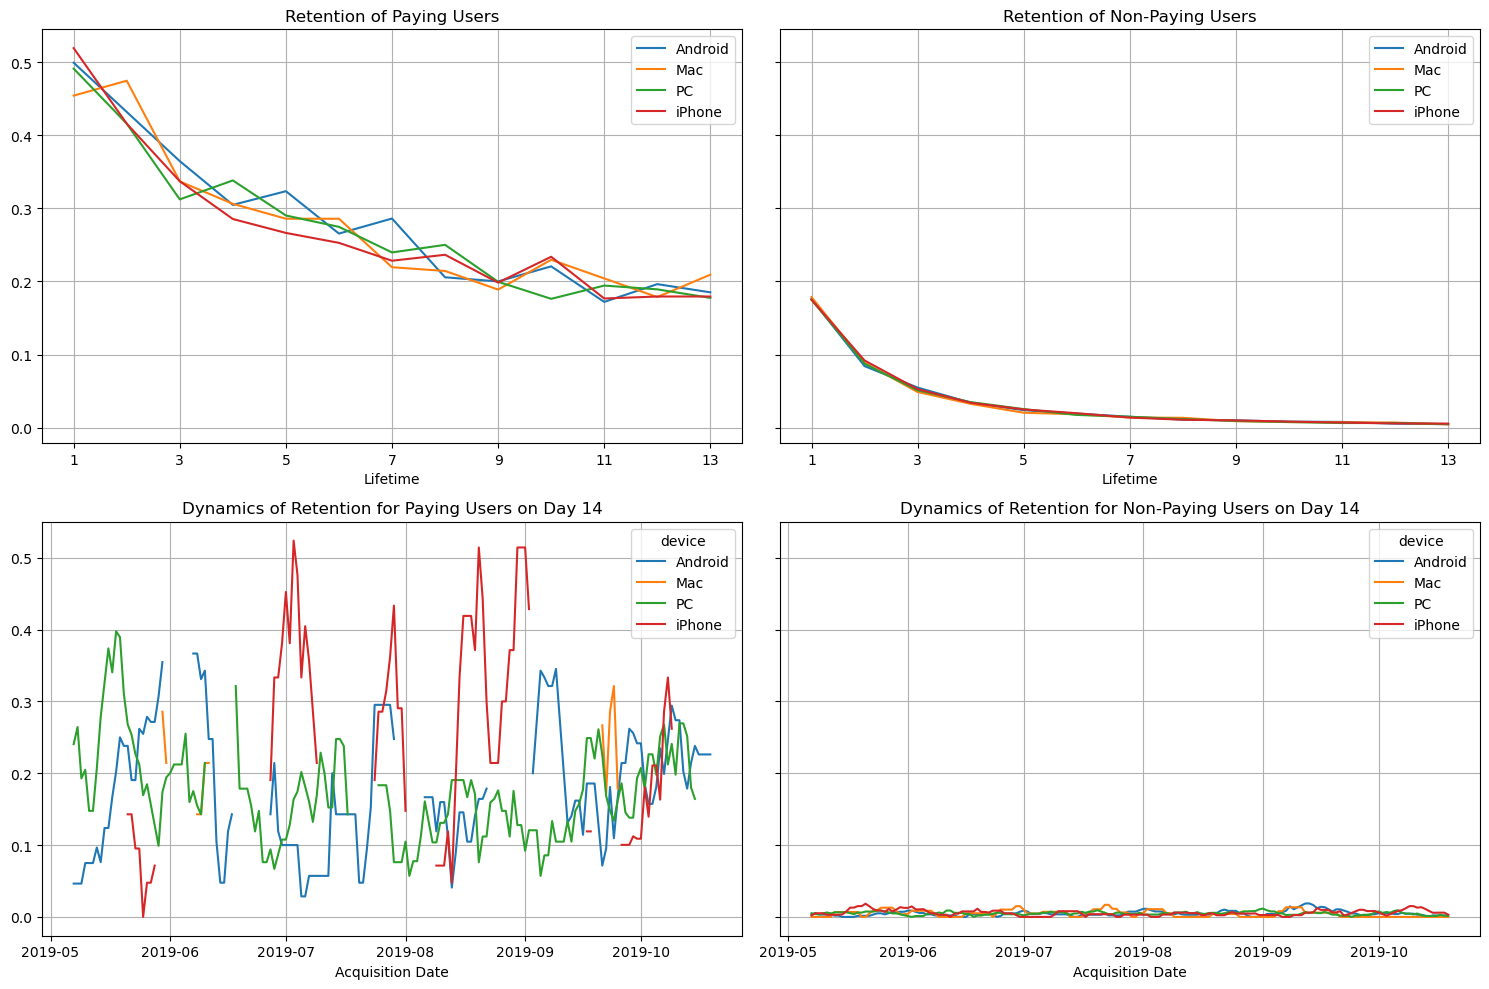

In [110]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles[profiles['region'] != 'United States'], visits[visits['region'] != 'United States'], observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### LTV, CAC and ROI dynamics in Europe by device

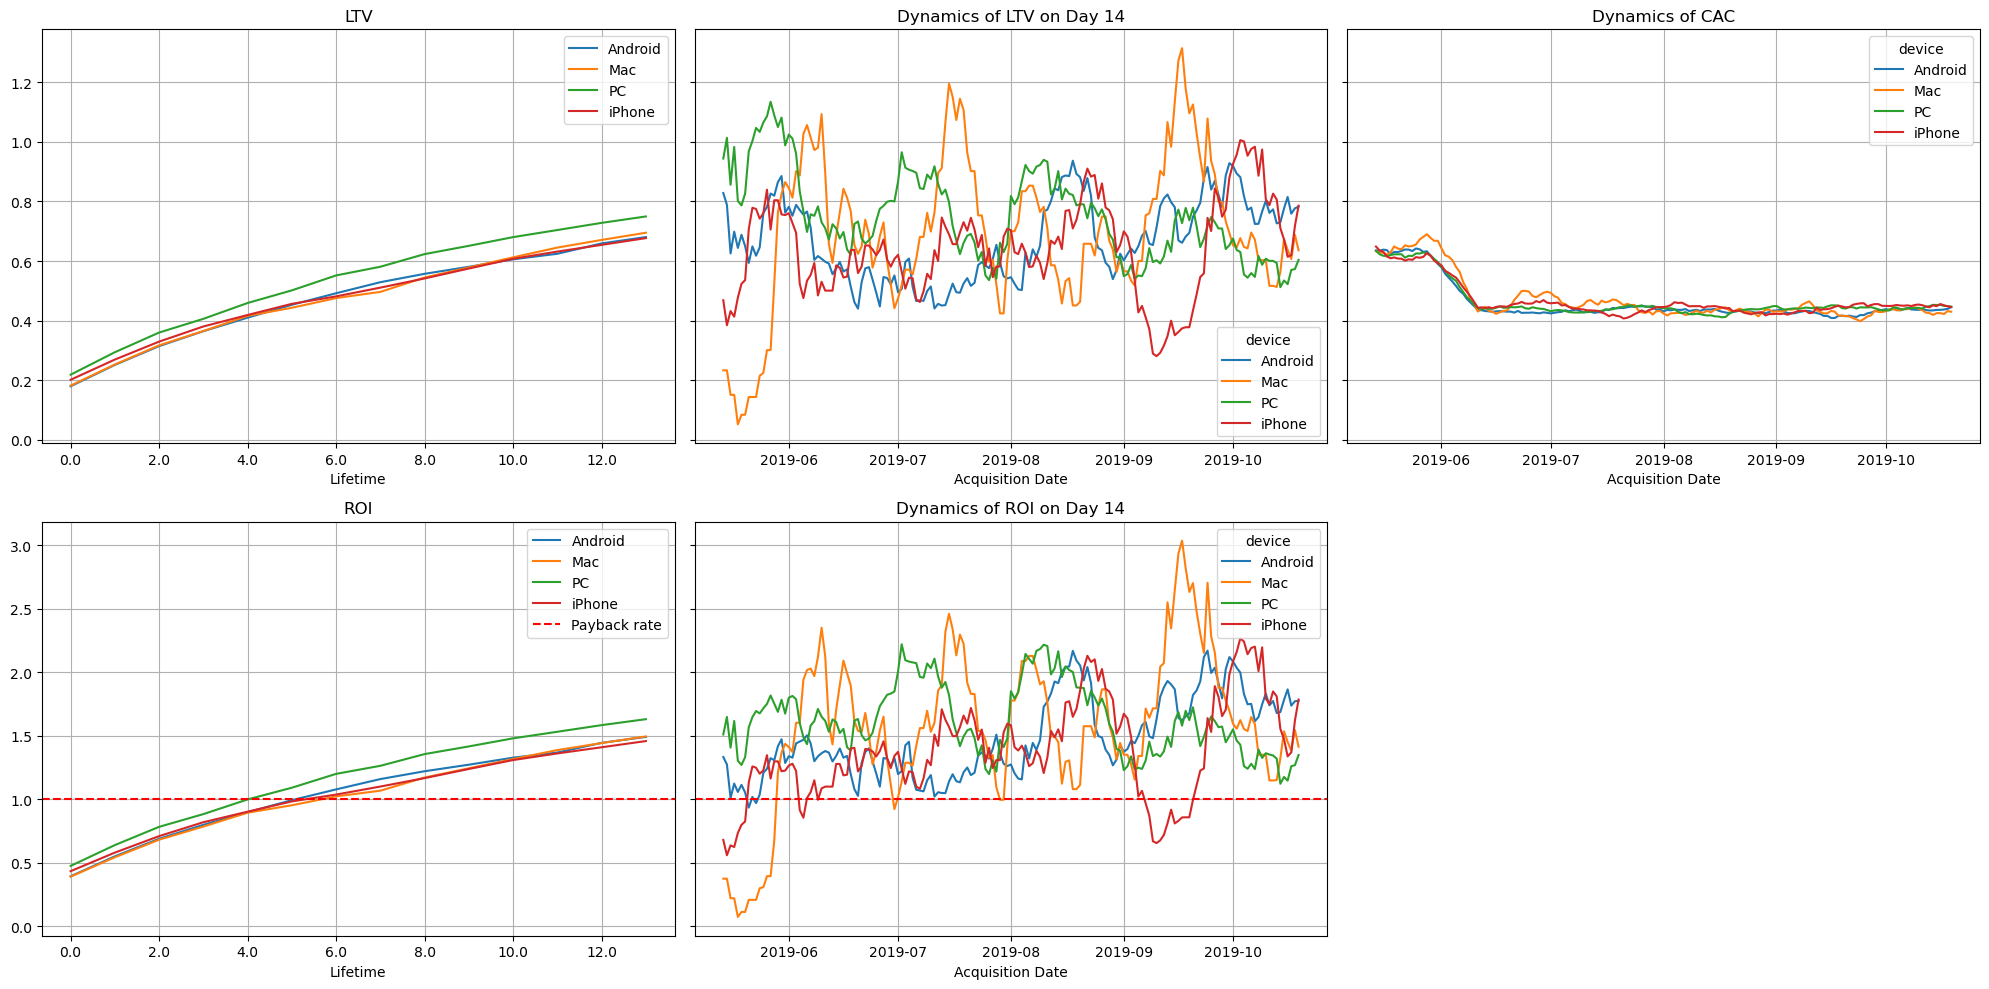

In [112]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles[(profiles['channel'] != 'organic')&(profiles['region'] != 'United States')], orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Summary:** LTV in Europe by devices is positive, showing a more confident upward trend than by channels. Retention of non-paying users is normal, but paying users are on the decline. Each device is profitable, and CAC by devices is stable.

## Reasons for inefficiency

The reasons for inefficiency will be divided into two seperate groups: *main* and only problem, which has been defined during the conducted analysis, and the other *possible* issues, which couldn't be confirmed according to the identified patterns.

1. Proven reason

The issue of profitability exists not only in the USA but also in Europe. In Europe it is minor and concerns only one agency. Profitability does not depend on devices -- **it is solely about the channels** (otherwise, it would not be the case that no device is profitable in the USA while all are profitable in Europe). Each continent has its problematic agencies. In the USA these are FaceBoom and TipTop, in Europe it is AdNonSense.

2. Possible extra reasons:
   - Technical issues with devices: Apple and Android devices may have a few unresolved technical issues affecting user experience, leading to retention problems.
   - Market saturation: the market for apps may be saturated, making it harder to attract new customers or retain existing ones.
   - Limited targeting and personalization: A lack of personalized marketing and retention strategies might lead to higher churn rates among paying users.
   - Changes in consumer behavior: Shifts in consumer preferences or behaviors may be affecting retention and engagement levels.

## Recommendations:

1. To shift the focus to the top-performing agencies that have proven their profitability, such as YRabbit, RocketSuperAds, and Media Tornado in the USA, and LeapBob and lambdaMediaAds in Europe.
2. To reduce the intensity or even completely exclude cooperation with such agencies as FaceBoom, TipTop and AdNonSense. 
3. To develop targeted marketing campaigns that focus on user segments, especially for paying customers, to enhance engagement and retention.
4. To continuously monitor the performance of acquisition channels and switch to more efficient ones while minimizing investments in underperformers.
5. To implement A/B testing for marketing strategies, user onboarding processes and engagement tools to identify what works best and optimize it accordingly.
6. To strengthen customer support: Providing excellent customer support can help retain users and address any issues that arise promptly.
7. To keep a close watch on market trends and consumer behavior to adapt strategies proactively to changing circumstances